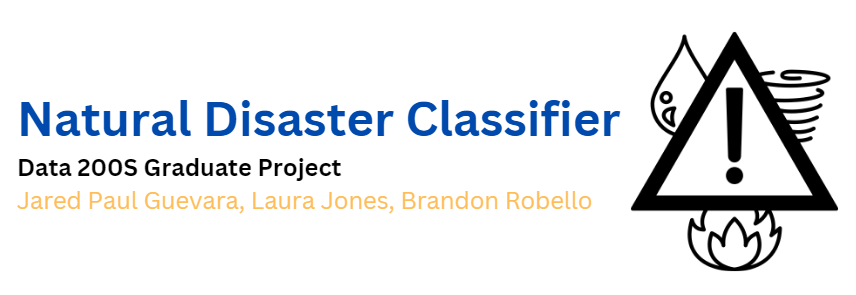


# Loading Data


**Importing the necessary utility functions, required libraries and packages needed for our classifier:**


In [3]:
import json
from zipfile import ZipFile

from data_utils import get_images, get_labels 
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import numpy as np
from skimage.filters import gabor_kernel
from tqdm import tqdm

**Loading the dataset from the mounted Google Drive:**


In [4]:
# Create a list containing the three different natural disasters we'll be investigating
disaster_list = ["hurricane-matthew", "socal-fire", "midwest-flooding"]

# Initializing data as a dictionary of dictionaries in image:label format
data = {}
split = "train"
config_path = './config.json'

with open(config_path) as config_file:
    config = json.load(config_file)
    data_zip = config['data_zip']
    data_dir = config['data_dir']

with ZipFile(data_zip) as zip_file:
    zip_file.extractall('../data/')

for disaster in disaster_list:
    print(f"Loading {split}ing images and labels from the {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

Loading training images and labels from the hurricane-matthew dataset...
Loading training images and labels from the socal-fire dataset...
Loading training images and labels from the midwest-flooding dataset...


# Exploratory Data Analysis (EDA)


Our principal EDA consists of the following tasks:

1. Calculating basic statistics, such as:

- Number of images per diaster type (via the length of dictionaries)
- Distribution of image heights, widths, and total sizes (via histograms)
- Distribution of damage labels (via bar charts)

2. Exploring insightful image features

- Color intensity distributions of each red, blue, and green channels per disaster (via histograms)

3. Creating the dataframes that contain features for each image

- Two dataframes:
  - `task_1_df` - contains images and features from both `socal-fire` and `midwest-flooding`
  - `task_2_df` - contains images and features from `hurricane-matthew`
- Verifying that our data has no `NaN` values (via df.isna())

4. Visualizing images under different color channels and image processing features (Sobel, LBP, Gabor)
5. Performing `.groupby()` operations on disaster type (Task 1) and label (Task 2) to identify possible features for model

- Mean total pixels and average pixel intensity are considerably higher in the `socal-fire` images set compared to the `midwest-flooding`


**Finding the total number of images per disaster:**

`hurricane-matthew` seems to have the largest number of images among the disasters. This makes sense considering we will most likely need to extract more features and fit our model to correctly label unseen data. `socal-fire` and `midwest-flooding` may as well be combined, since images from both will be used to train the first model to differentiate images from each other.


In [7]:
# Number of images in Dataset
for disaster in disaster_list:
  print(f"For {disaster}, there are {len(data[disaster]['images'])} images in the dataset.")

For hurricane-matthew, there are 11151 images in the dataset.
For socal-fire, there are 8380 images in the dataset.
For midwest-flooding, there are 7004 images in the dataset.


**Visualizing the distribution of image heights, widths, and total sizes per disaster:**


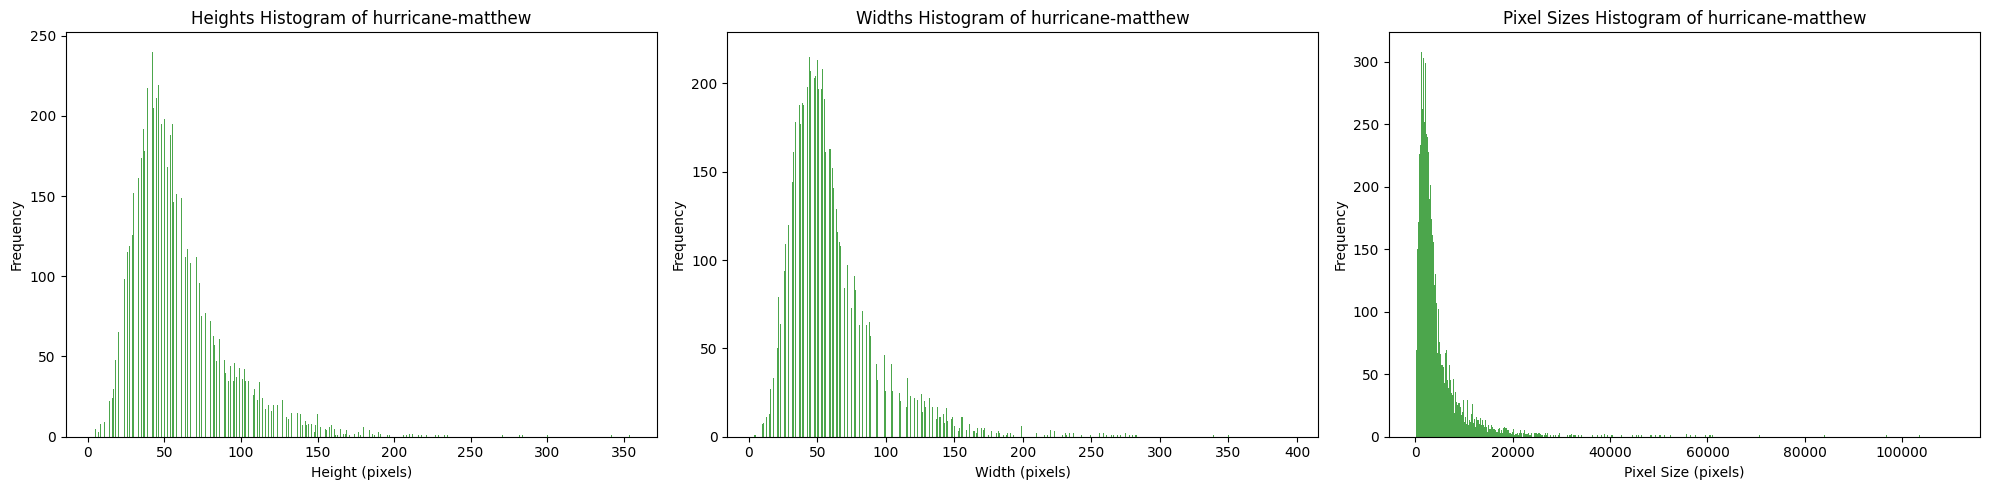

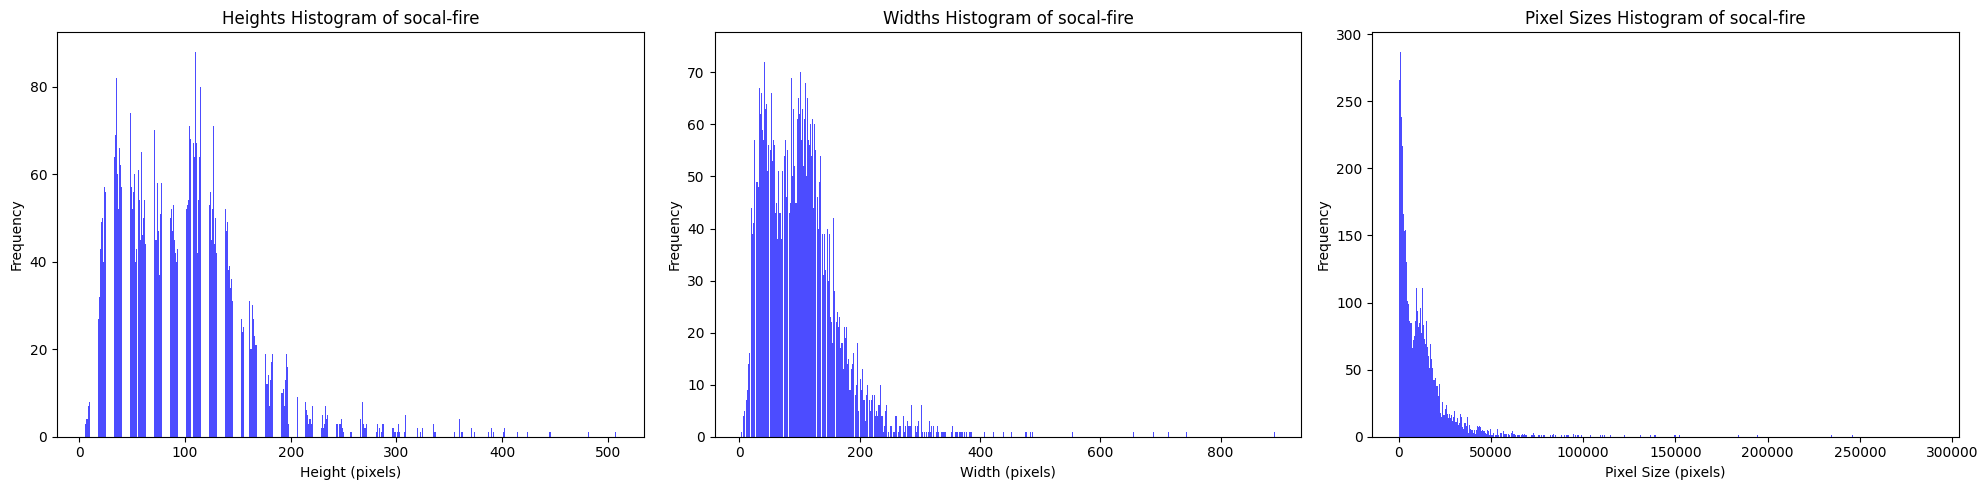

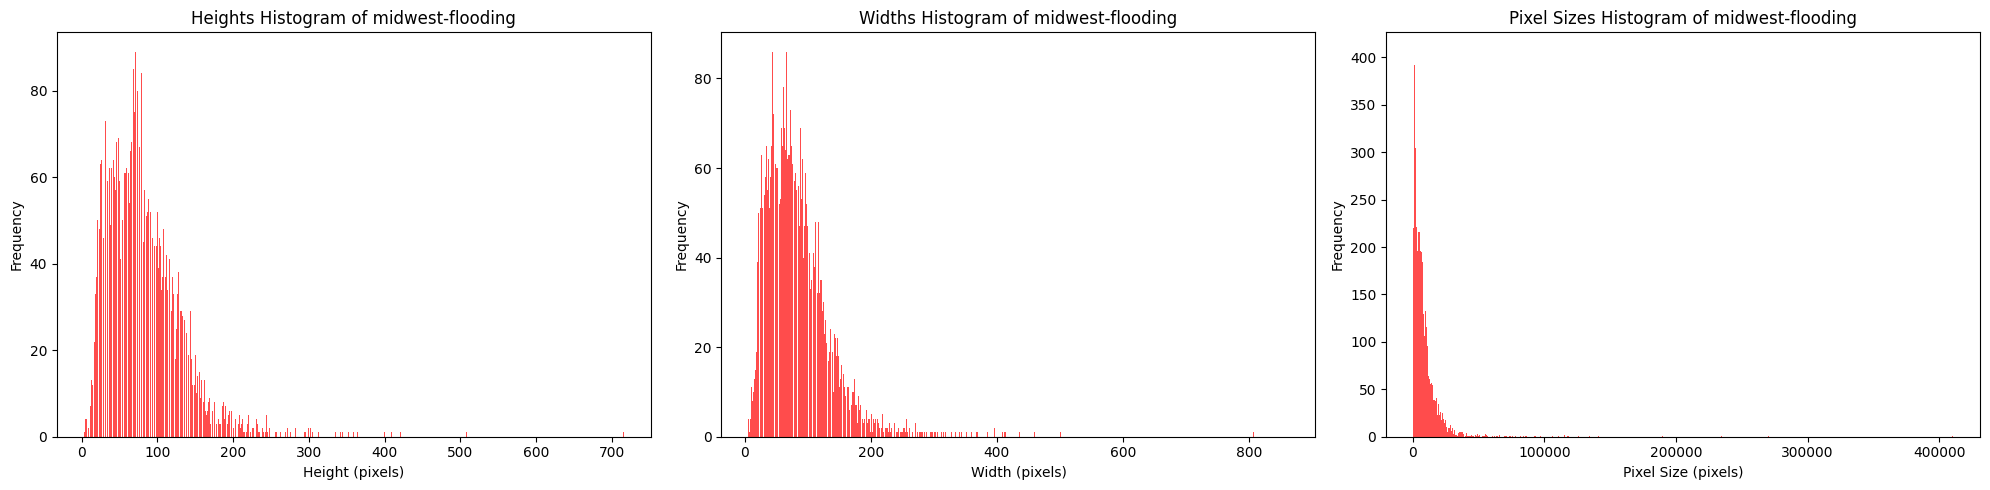

In [8]:
# Get image sizes and plot distribution
color_dict = {"hurricane-matthew":"green", "socal-fire": "blue", "midwest-flooding":"red"}

total_pixel_sizes = {}
heights = {}
widths = {}

for disaster in disaster_list:
  total_pixel_sizes[disaster] = []
  heights[disaster] = []
  widths[disaster] = []

  for i in range(len(data[disaster]['images'])):
    image = data[disaster]['images'][i]
    height = image.shape[0]
    width = image.shape[1]
    total_pixel_size = height * width

    total_pixel_sizes[disaster].append(total_pixel_size)
    heights[disaster].append(height)
    widths[disaster].append(width)

  # Print Statements of min and max
  # print(f"{disaster} Height min: {min(Heights[disaster])} & max: {max(Heights[disaster])}")
  # print(f"{disaster} Width min: {min(Widths[disaster])} & max: {max(Widths[disaster])}")
  # print(f"{disaster} TPS min: {min(Total_pixel_sizes[disaster])} & max: {max(Total_pixel_sizes[disaster])}")

  # Create a figure to contain the subplots with a size of 15x10
  plt.figure(figsize=(20, 5))

  # Heights histogram
  plt.subplot(1, 3, 1)  # 1st row, 1st col
  plt.hist(heights[disaster], bins=1000, color=color_dict[disaster], alpha=0.7)
  plt.title(f'Heights Histogram of {disaster}')
  plt.xlabel('Height (pixels)')
  plt.ylabel('Frequency')

    # Widths histogram
  plt.subplot(1, 3, 2)  # 2nd row, 1st col
  plt.hist(widths[disaster], bins=1000, color=color_dict[disaster], alpha=0.7)
  plt.title(f'Widths Histogram of {disaster}')
  plt.xlabel('Width (pixels)')
  plt.ylabel('Frequency')

      # Total Pixel Sizes histogram
  plt.subplot(1, 3, 3)  # 3rd row, 1st col
  plt.hist(total_pixel_sizes[disaster], bins=1000, color=color_dict[disaster], alpha=0.7)
  plt.title(f'Pixel Sizes Histogram of {disaster}')
  plt.xlabel('Pixel Size (pixels)')
  plt.ylabel('Frequency')


  # Adjust the layout
  plt.tight_layout()
  plt.show()

**Visualizng the damage label distributions per disaster:**

Note: Task 1's goal is to differentiate between images from `socal-fire` and `midwest-flooding`. Task 2's goal is to classify images from `hurricane-matthew` on a scale from 1 through 3. The difference in goals explains why the distribution of labels is different between all three disasters, with the majority of labels from `socal-fire` and `midwest-flooding` being 0 and 3 vs. a more spread out distribution from `hurricane-matthew`.


Value counts for labels in hurricane-matthew:
0    2631
1    5236
2    1544
3    1740
Name: count, dtype: int64


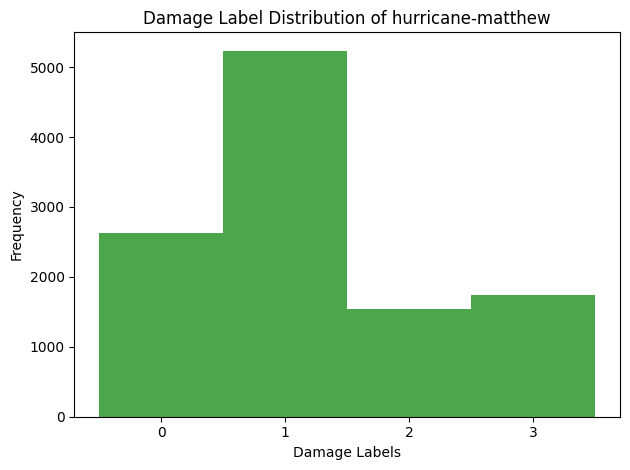

Value counts for labels in socal-fire:
0    7204
1      69
2      43
3    1064
Name: count, dtype: int64


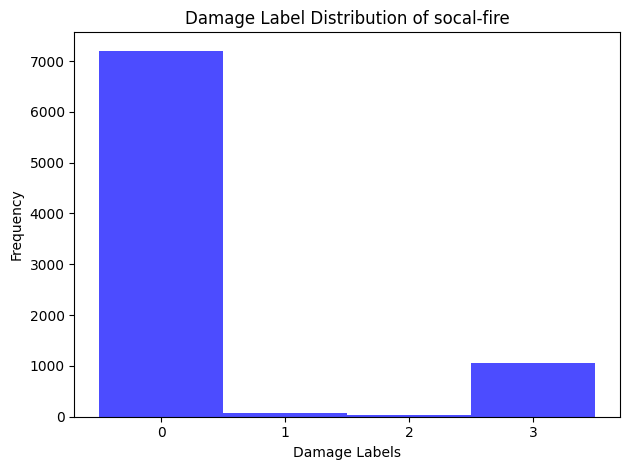

Value counts for labels in midwest-flooding:
0    6734
1     114
2      97
3      59
Name: count, dtype: int64


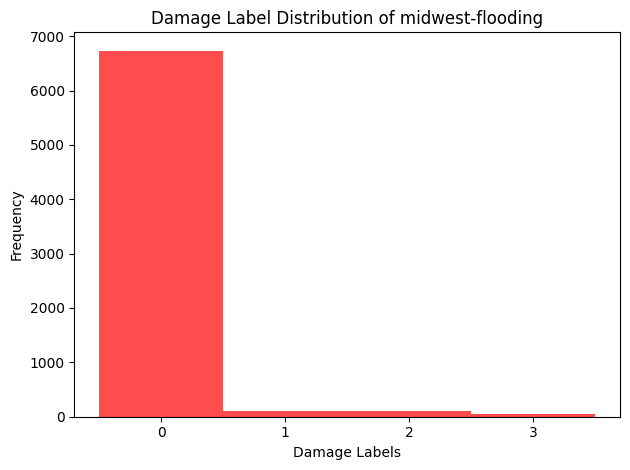

In [9]:
# Get image labels and plot distribution

for disaster in disaster_list:
    # Get labels for each disaster
    disaster_labels = data[disaster]['labels']

    # Print statements of min and max
    print(f"Value counts for labels in {disaster}:\n{pd.Series(data[disaster]['labels']).value_counts().sort_index()}")

    # Create a histogram for label distribution with bins for each label
    plt.hist(disaster_labels, bins=[0, 1, 2, 3, 4], align='left', color=color_dict[disaster], alpha=0.7)
    plt.title(f'Damage Label Distribution of {disaster}')
    plt.xlabel('Damage Labels')
    plt.ylabel('Frequency')
    plt.xticks([0, 1, 2, 3])  # Set x-ticks to correspond to the discrete labels

    # Adjust the layout
    plt.tight_layout()
    plt.show()

**Visualizing the distribution of color channel intensities (red, green, blue) per disaster:**

From looking at the histograms, it may be worthwhile to consider the mean intensity of images per disaster in completing Task 1, as the average from each color channel in `socal-fire` is higher than in `midwest-flooding`. Since `hurricane-matthew` will be compared amongst the damage labels, additional EDA could be conducted to visualize the distribution of intensities per label.


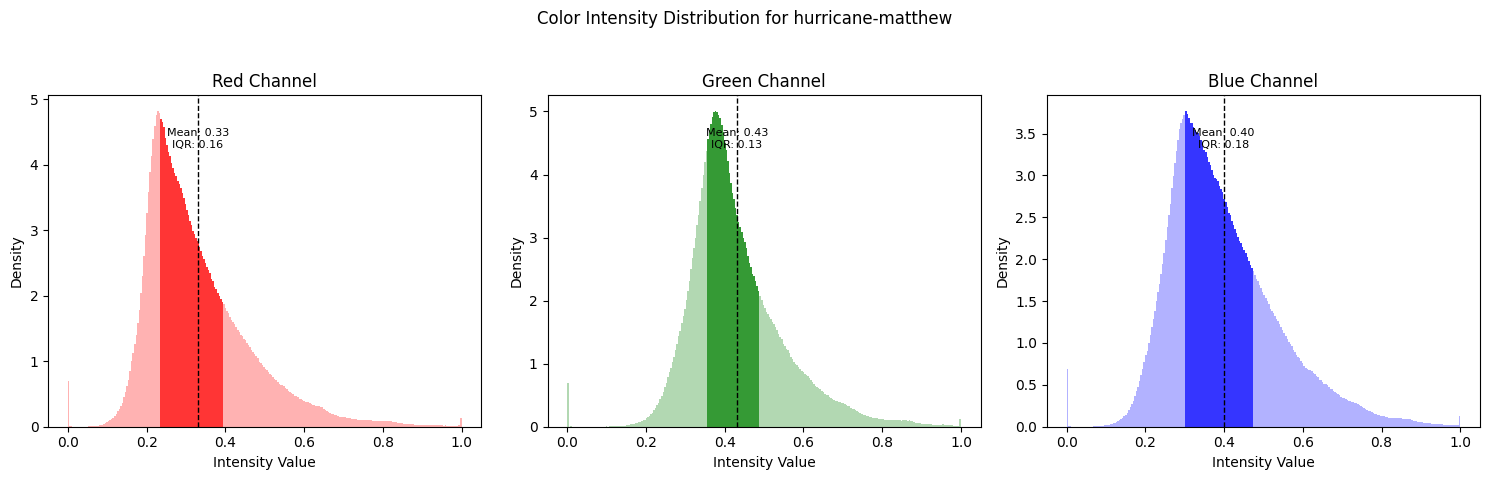

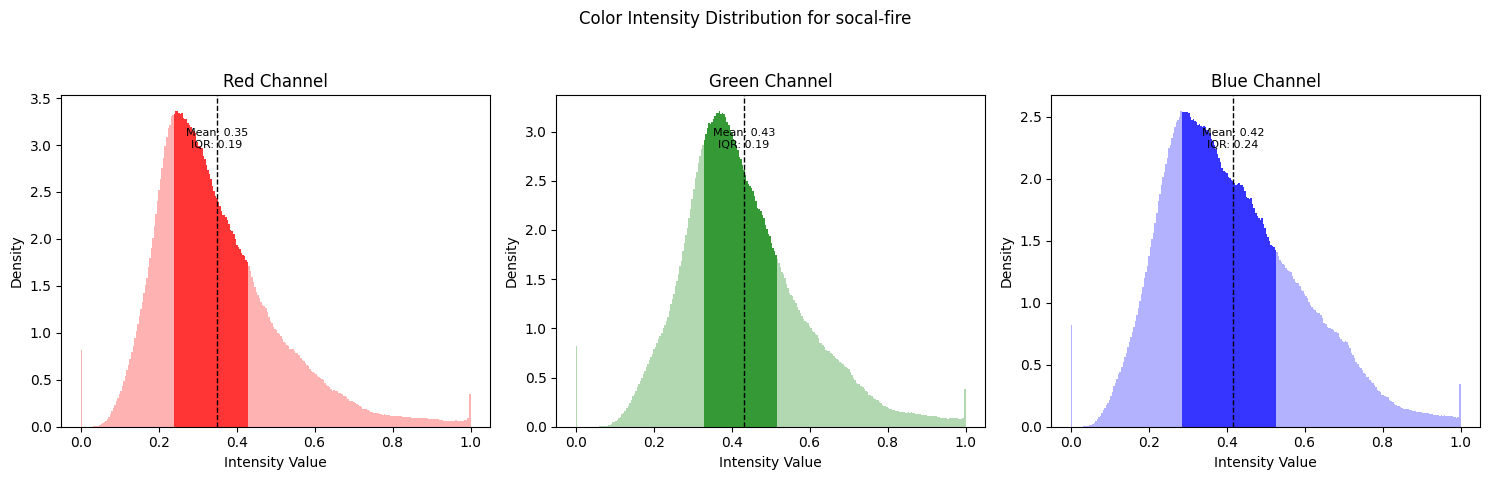

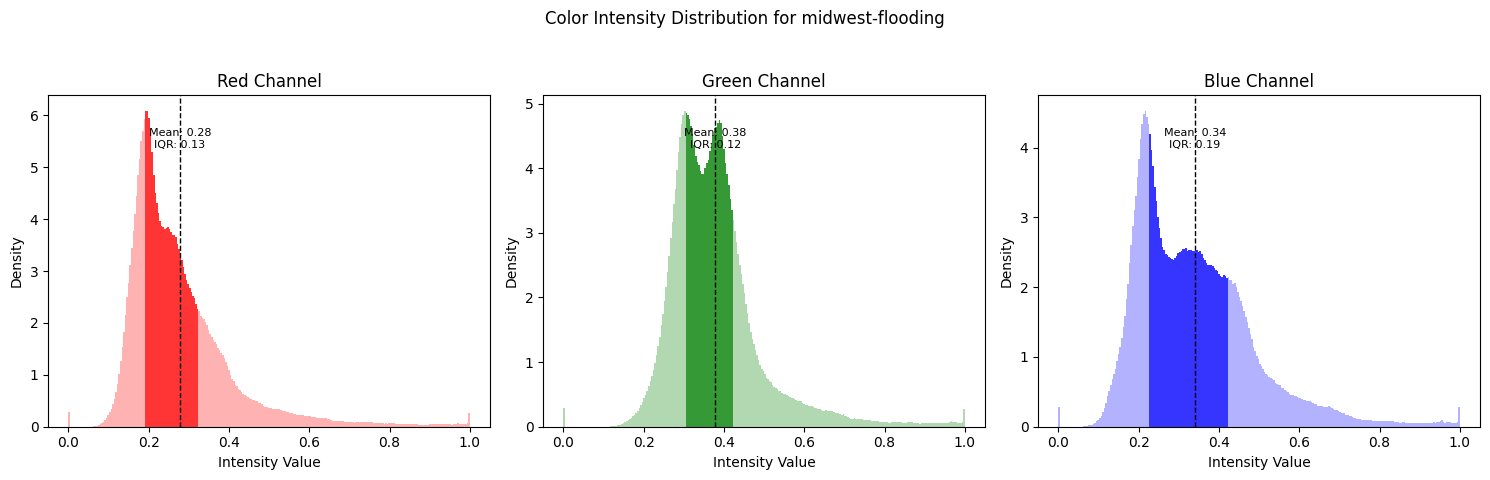

In [10]:
# Look at color values for images in each disaster classification

# Data transformation idea, increase constrast

common_size = (128, 128)  # Normalize image size for consistency
num_samples = 500

for disaster in disaster_list:
    # Accumulators for color intensities across all images in the disaster
    color_accumulators = {'red': [], 'green': [], 'blue': []}
    disaster_img_dataset = data[disaster]['images']

    # Take a random sample of the image dataset
    sampled_indices = np.random.choice(range(len(disaster_img_dataset)), size=min(num_samples, len(disaster_img_dataset)), replace=False)
    sampled_images = [disaster_img_dataset[i] for i in sampled_indices]

    for img in sampled_images:
        # Resize data transforamtion to common size
        img_resized = resize(img, common_size, anti_aliasing=True)
        img_flat = img_resized.reshape(-1, 3)

        # Normalize color intensities to 0-1 range
        img_normalized = img_flat / 255.0

        # Accumulate color intensities
        color_accumulators['red'].extend(img_flat[:, 0])
        color_accumulators['green'].extend(img_flat[:, 1])
        color_accumulators['blue'].extend(img_flat[:, 2])

    # Plotting the density histograms and mean for each color channel across the disaster
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Color Intensity Distribution for {disaster}")

    for i, color in enumerate(['red', 'green', 'blue']):
        plt.subplot(1, 3, i+1)

        color_data = np.array(color_accumulators[color])
        q1, q3 = np.percentile(color_data, [25, 75])
        iqr = q3 - q1

        # Histogram for the full data
        counts, bins, _ = plt.hist(color_data, bins=256, color=color, alpha=0.3, density=True)

        # Highlighting the IQR
        bin_centers = (bins[:-1] + bins[1:]) / 2
        for count, bin_center in zip(counts, bin_centers):
            if q1 <= bin_center <= q3:
                plt.bar(bin_center, count, width=bins[1]-bins[0], color=color, alpha=0.7, align='center')

        avg_intensity = color_data.mean()
        plt.axvline(avg_intensity, color='k', linestyle='dashed', linewidth=1)
        plt.title(f'{color.capitalize()} Channel')
        plt.xlabel('Intensity Value')
        plt.ylabel('Density')
        plt.text(avg_intensity, plt.ylim()[1]*0.9, f'Mean: {avg_intensity:.2f}\nIQR: {iqr:.2f}', ha='center', va='top', fontsize=8, color='k')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**Defining Sobel, LBP, and Gabor feature extraction functions:**


In [11]:
def generate_gabor_kernels(theta_vals, sigma_vals, frequency_vals):
    """
    Generate a collection of Gabor filter kernels with specified parameters.

    Args:
        theta_vals (list or array): Range of orientations for the Gabor filter kernels.
        sigma_vals (list or array): Range of sigma values (bandwidths) for the kernels.
        frequency_vals (list or array): Range of frequencies for the kernels.

    Returns:
        list: A list of Gabor kernels with specified parameters.
    """
    kernels = []
    for theta in theta_vals:
        for sigma in sigma_vals:
            for frequency in frequency_vals:
                kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    return kernels

def extract_combined_features(image, gabor_kernels):
    """
    Extract combined features (Sobel, Gabor, LBP) from an image and summarize with statistical measures.
    This version supports multiple Gabor kernels.

    Args:
        image (ndarray): An image array in RGB format.
        gabor_kernels (list): A list of Gabor kernels for feature extraction.

    Returns:
        ndarray: A 1D array (feature vector) summarizing the extracted features.
    """
    # Initialize dictionary to collect features
    features_dict = {}

    # Sobel features
    sobel_features = get_sobel_features(image).flatten()
    features_dict['sobel_mean'] = sobel_features.mean()
    features_dict['sobel_var'] = sobel_features.var()

    # Gabor features
    for i, kernel in enumerate(gabor_kernels):
        gabor_features = get_gabor_features(image, kernel).flatten()
        features_dict[f'gabor_{i}_mean'] = gabor_features.mean()
        features_dict[f'gabor_{i}_var'] = gabor_features.var()

    # LBP features
    lbp_features = get_local_binary_pattern(image).flatten()
    features_dict['lbp_mean'] = lbp_features.mean()
    features_dict['lbp_var'] = lbp_features.var()

    return features_dict


def visualize_feature_distribution(feature_df, disaster_type):
    """
    Visualize the distribution of the summary statistics for each dataset.

    Args:
        feature_df (DataFrame): DataFrame where each row is a feature vector and each column is a feature.
    """
    feature_names = feature_df.columns

    for feature_name in feature_names:
        plt.figure(figsize=(10, 6))
        sns.histplot(feature_df[feature_name], kde=True, bins=20)
        plt.title(f'Distribution of {feature_name} of {disaster_type}')
        plt.xlabel(feature_name)
        plt.ylabel('Density')
        plt.show()

**Using feature extraction and visualizing the feature space of Task A images (`midwest-flooding` & `socal-fire`) under different image processing filters:**


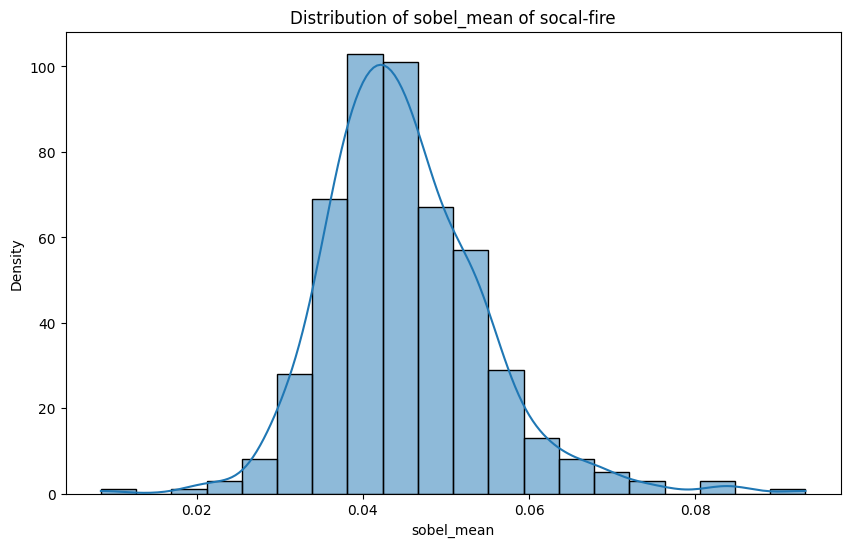

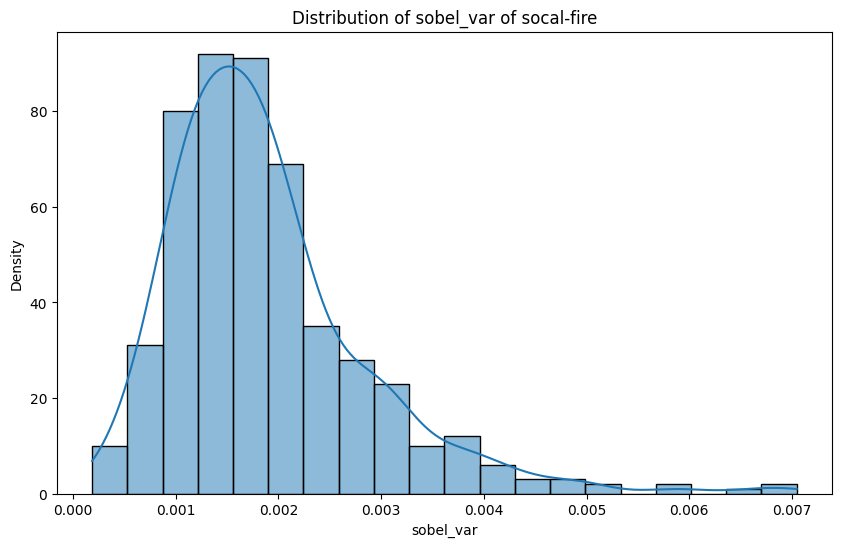

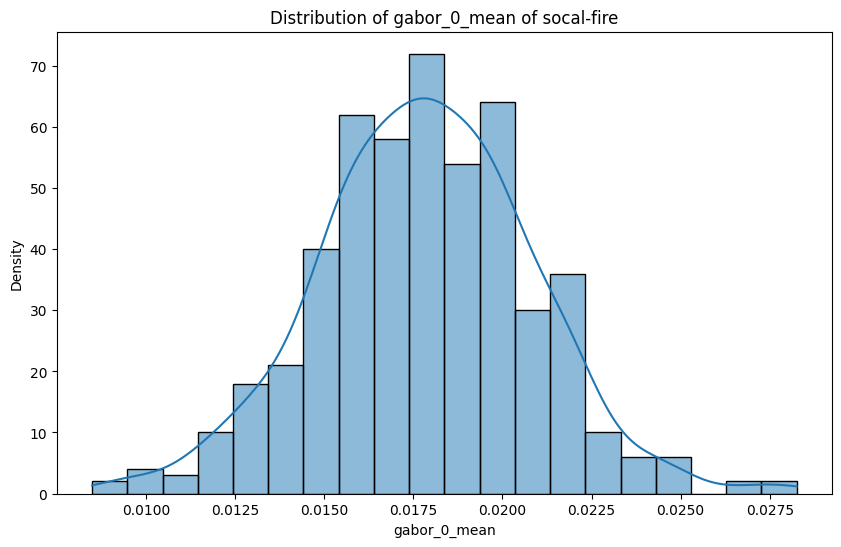

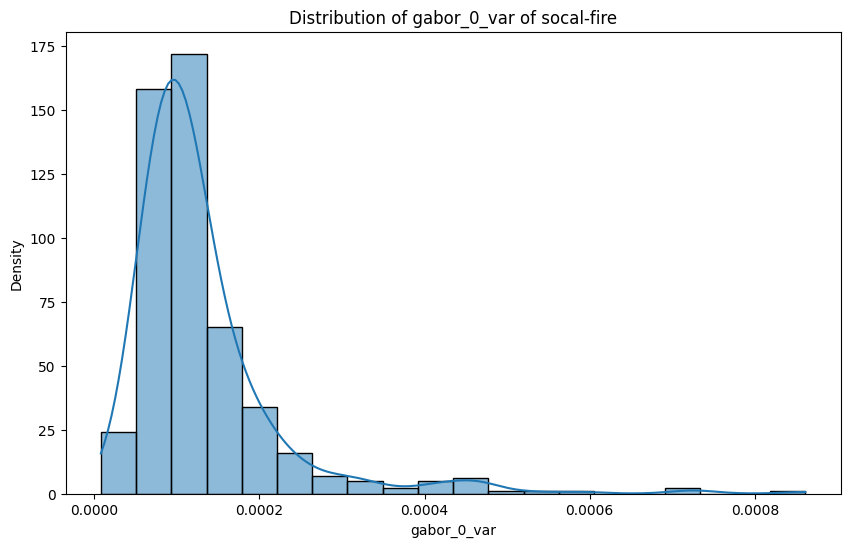

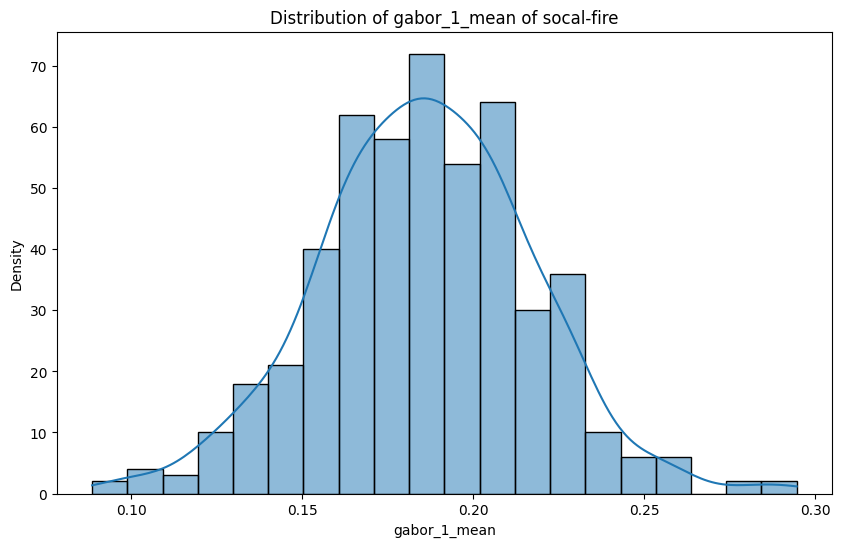

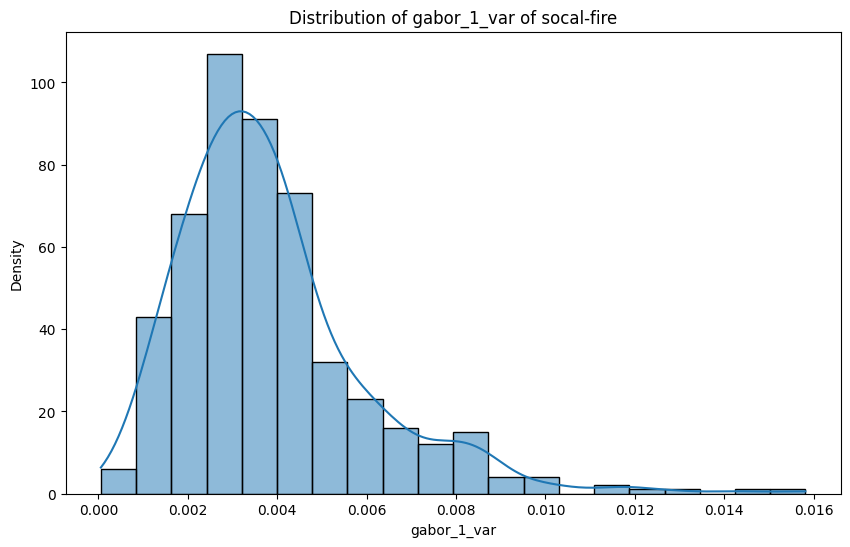

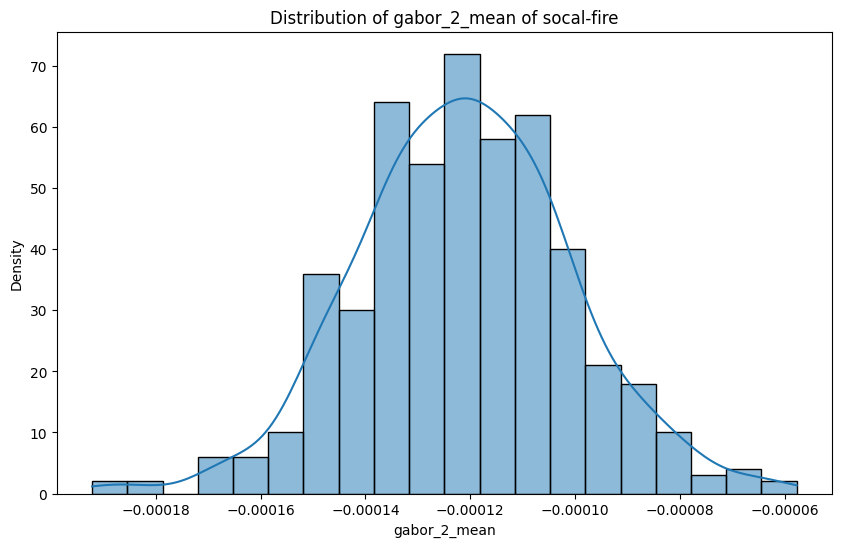

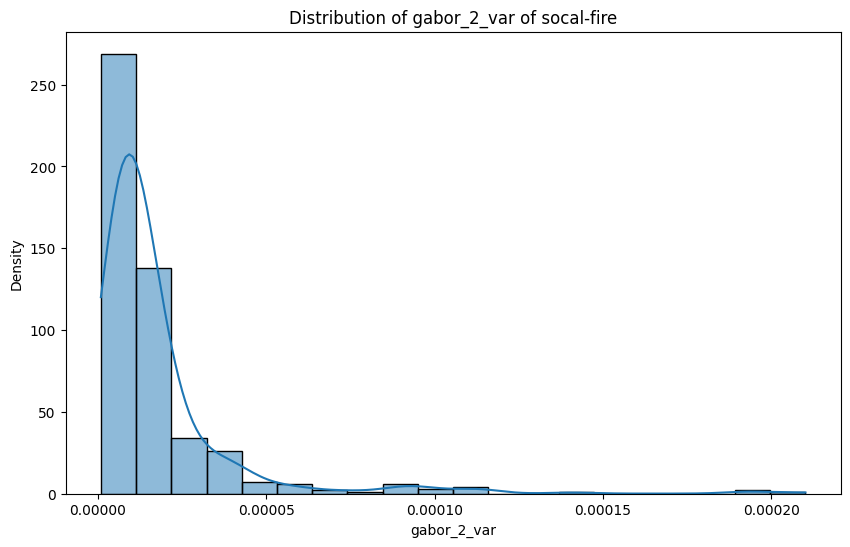

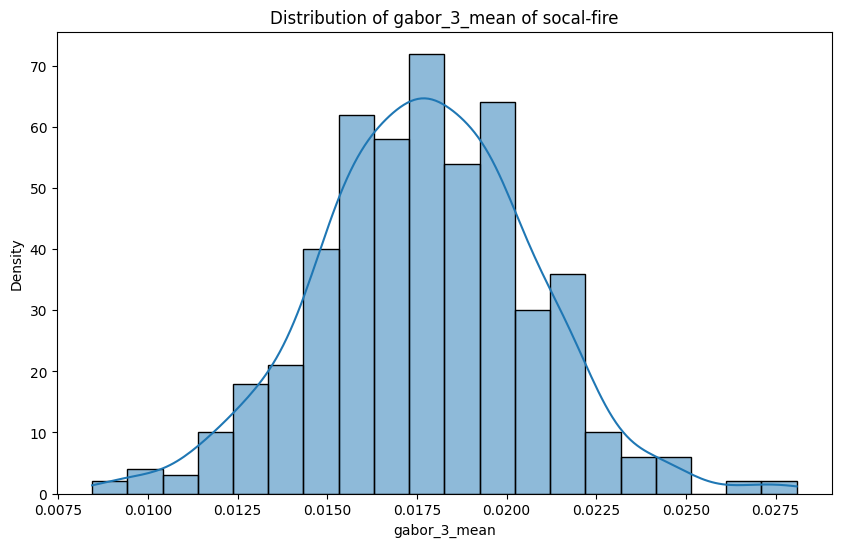

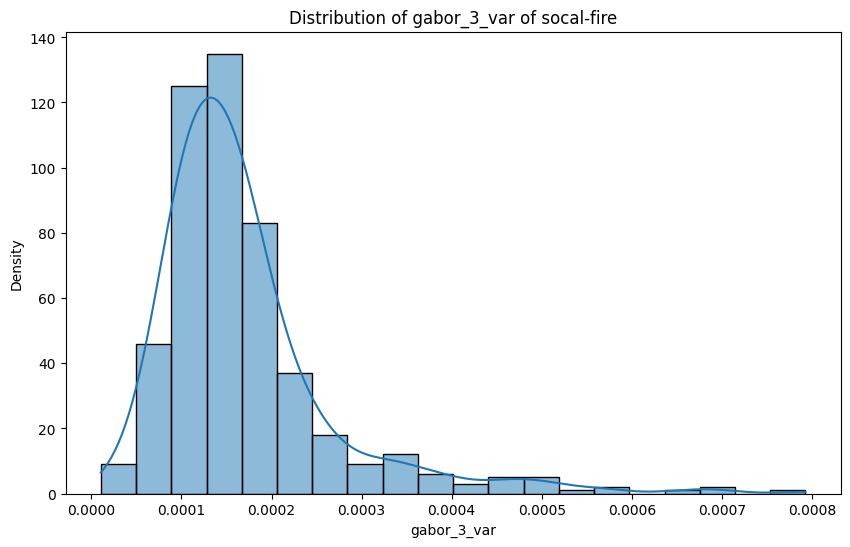

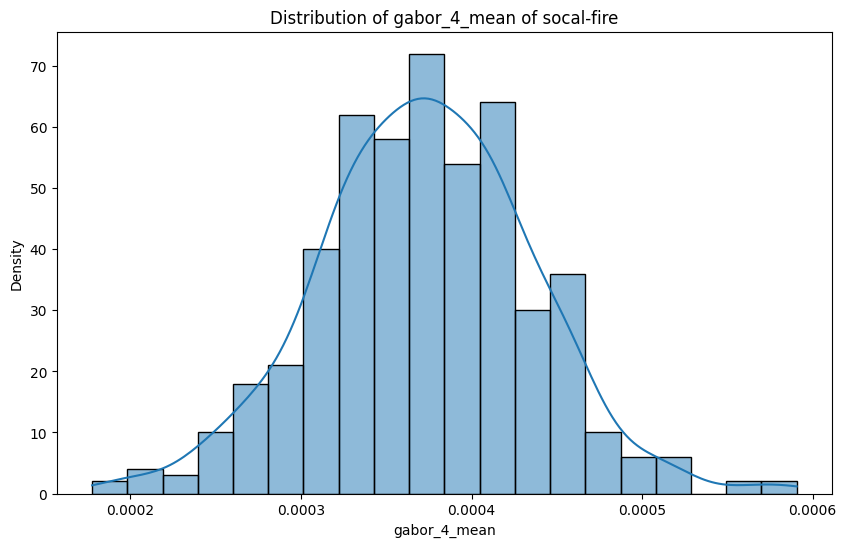

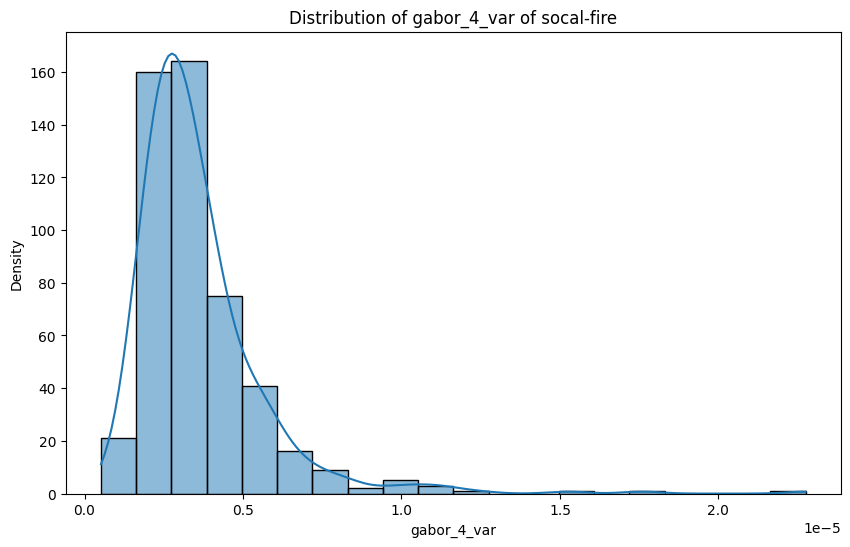

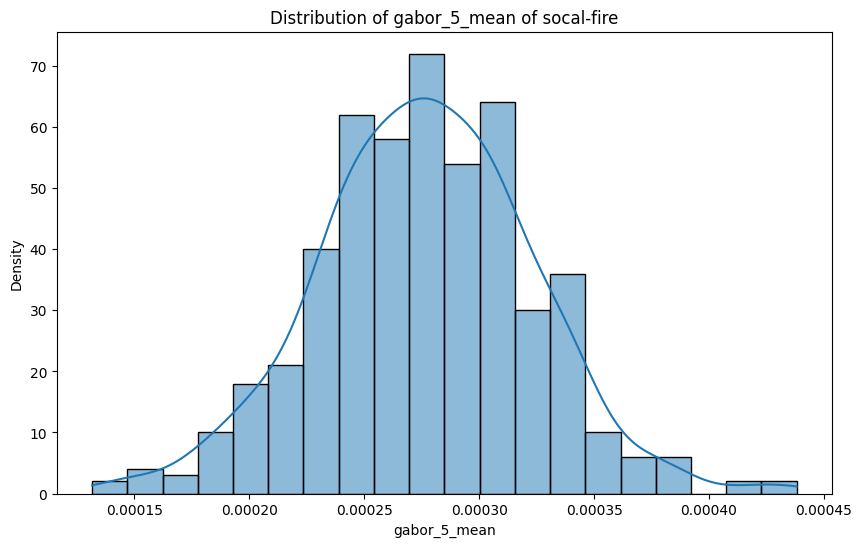

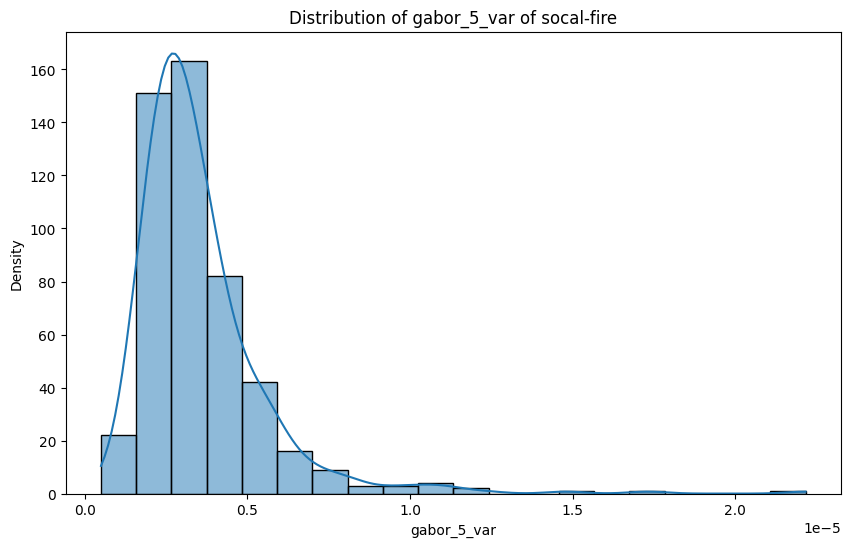

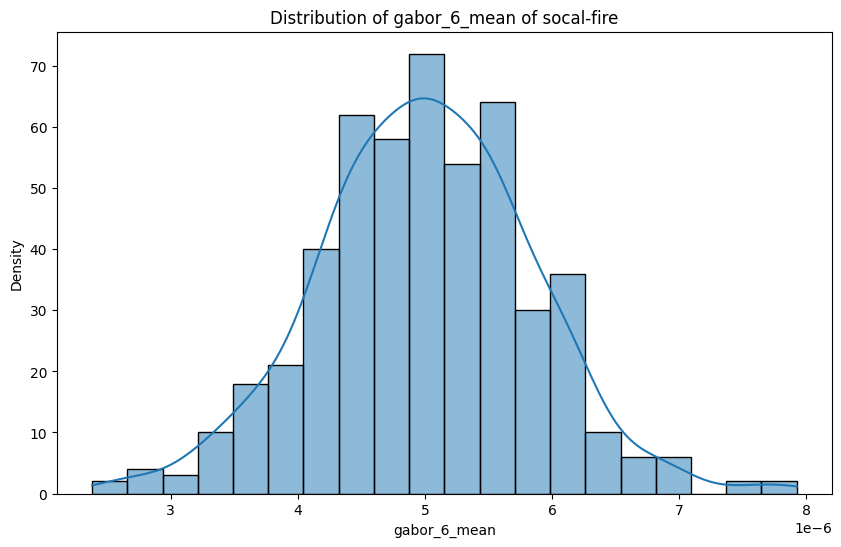

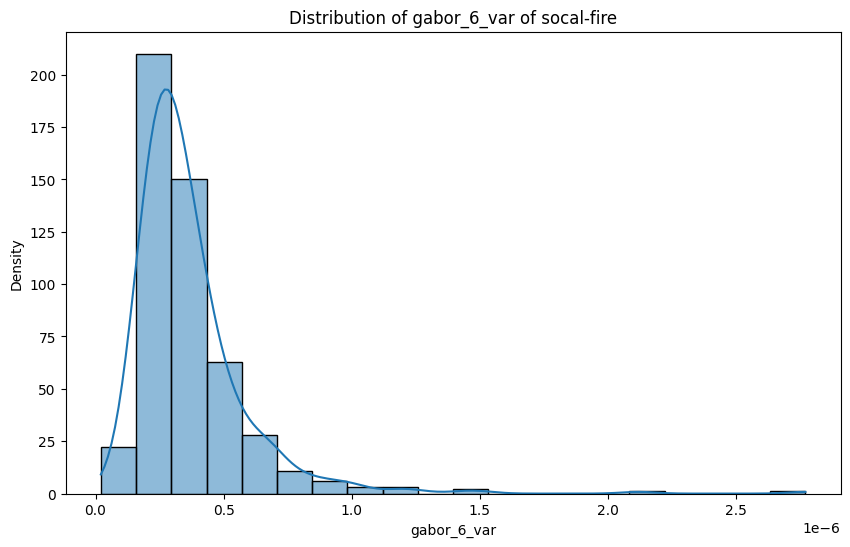

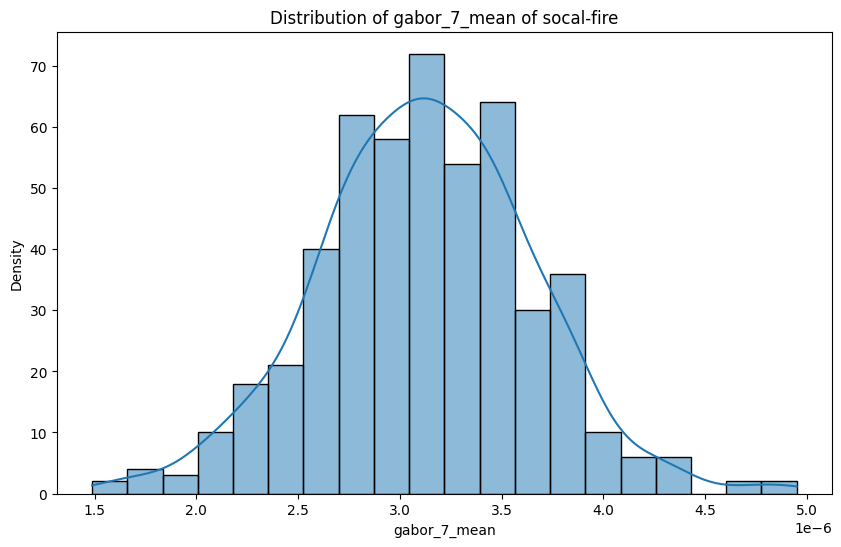

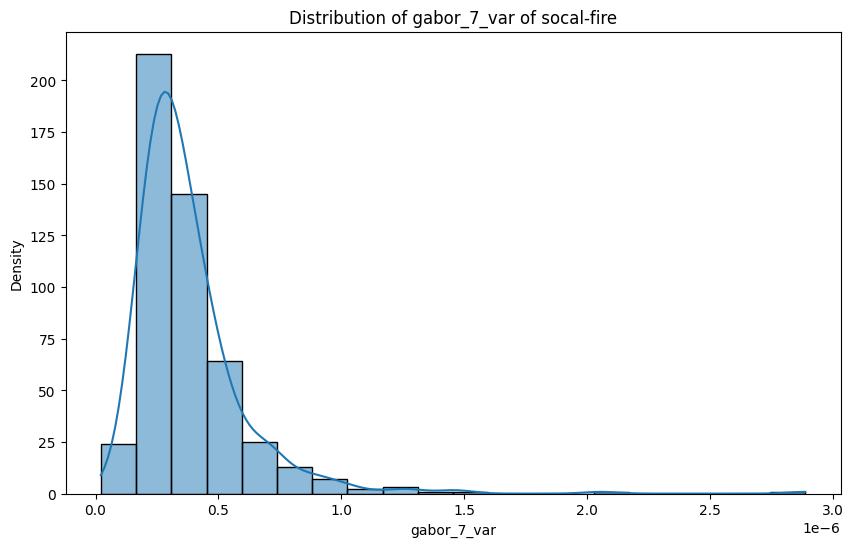

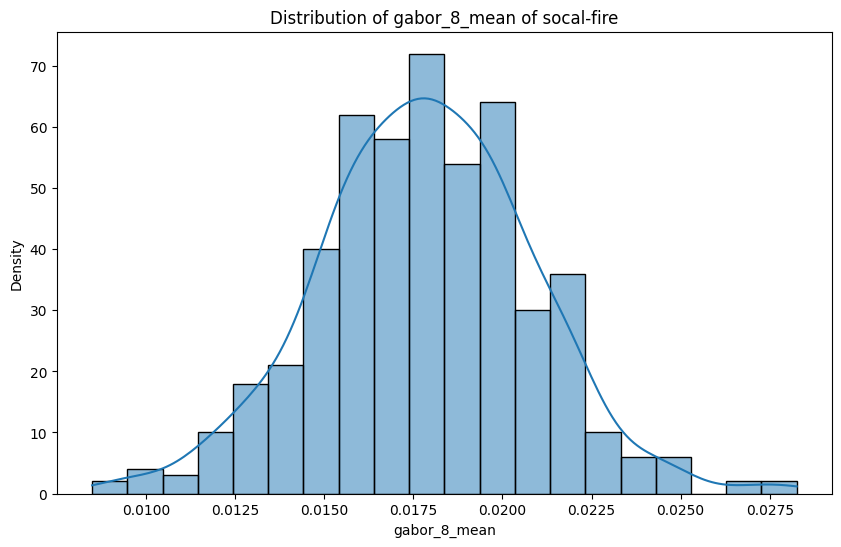

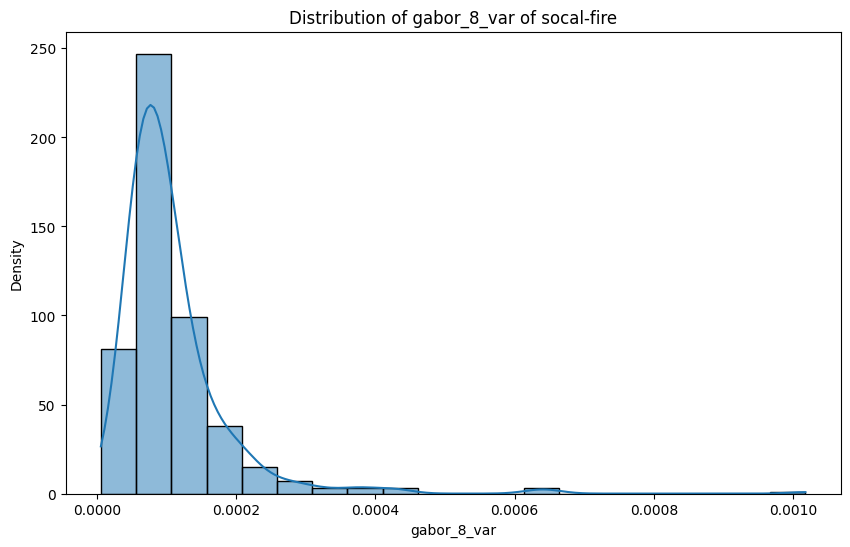

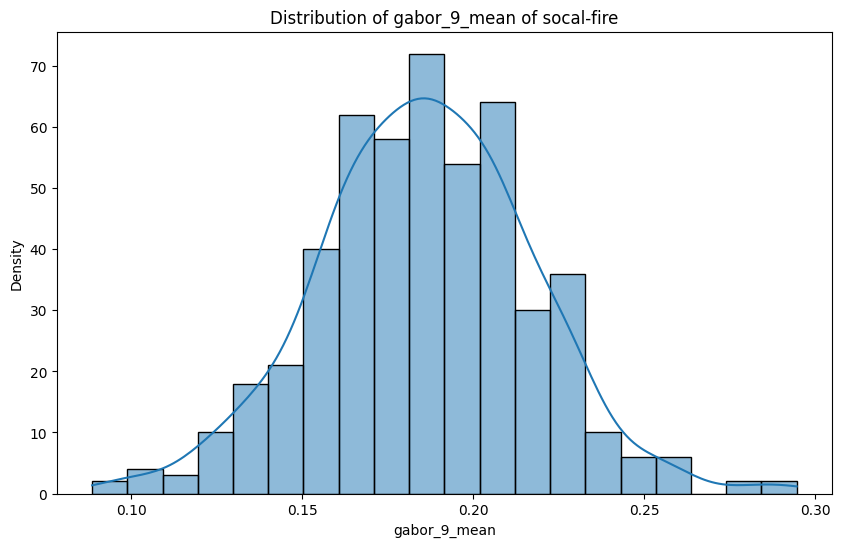

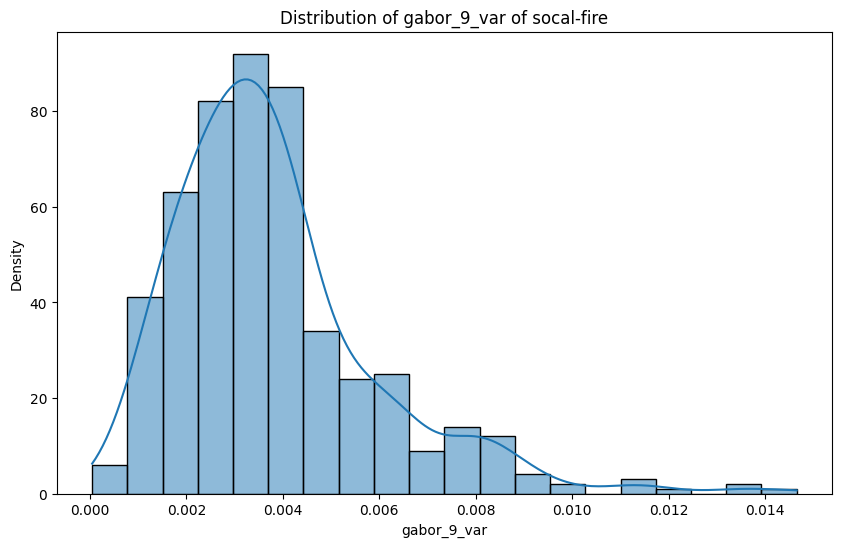

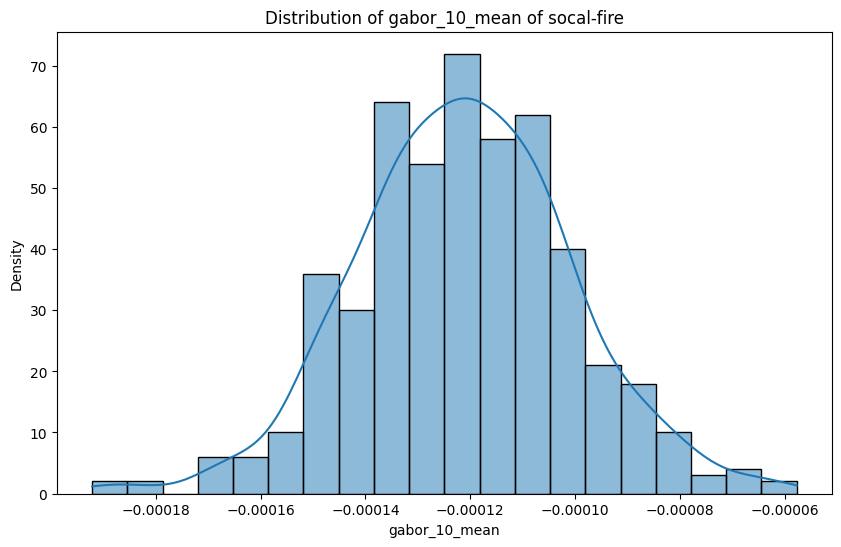

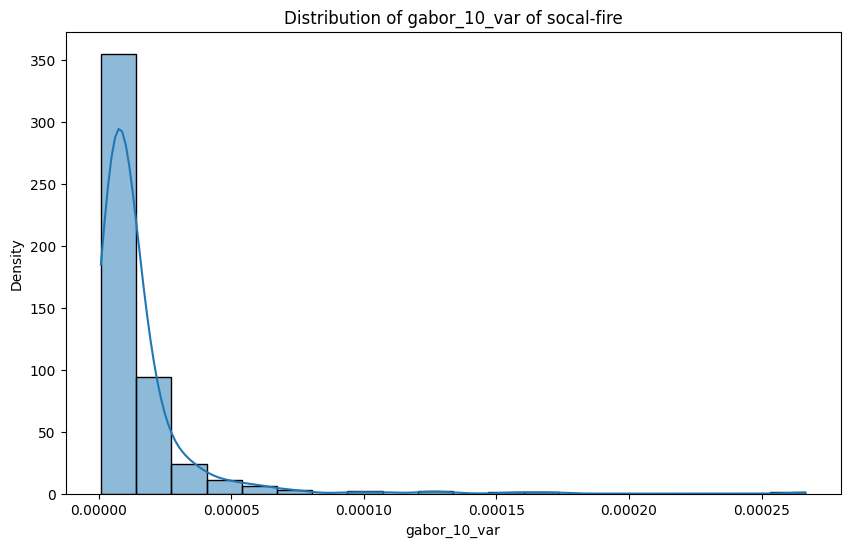

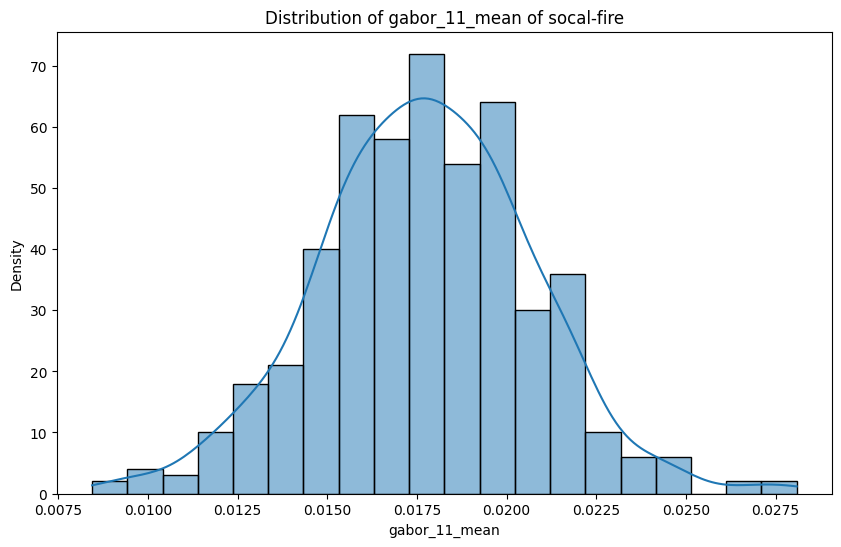

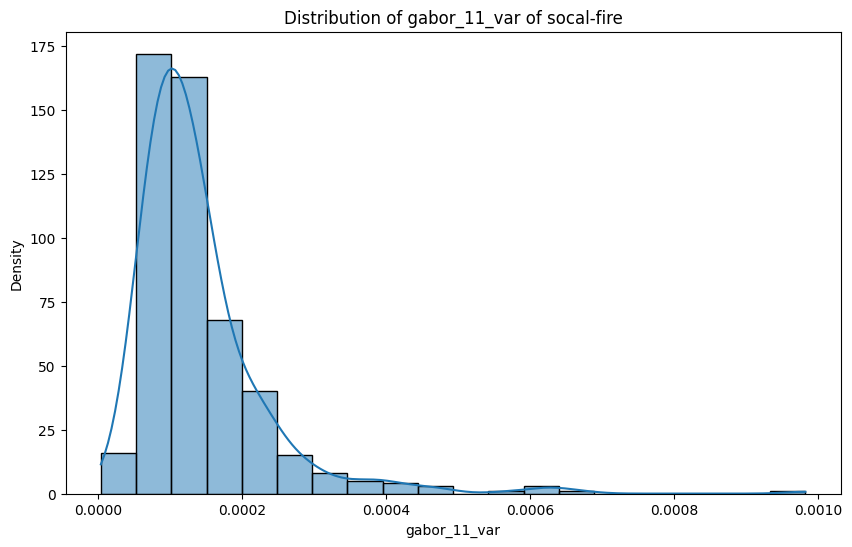

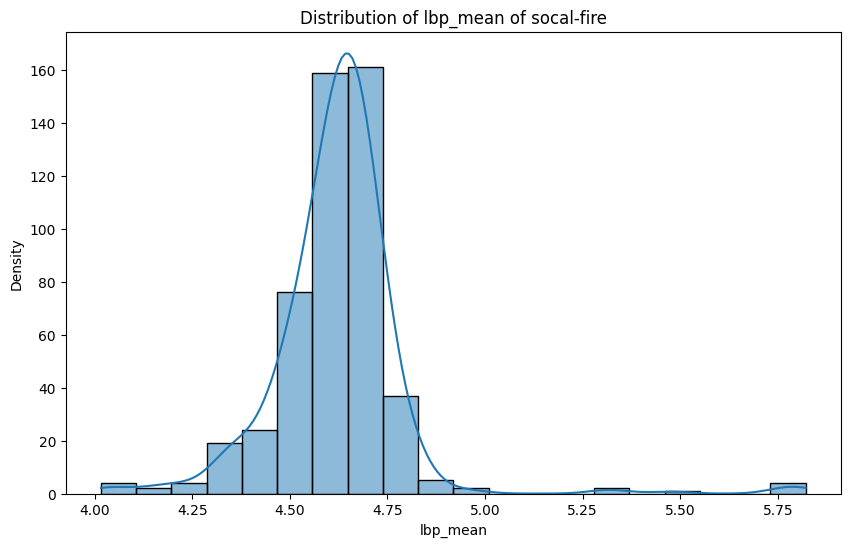

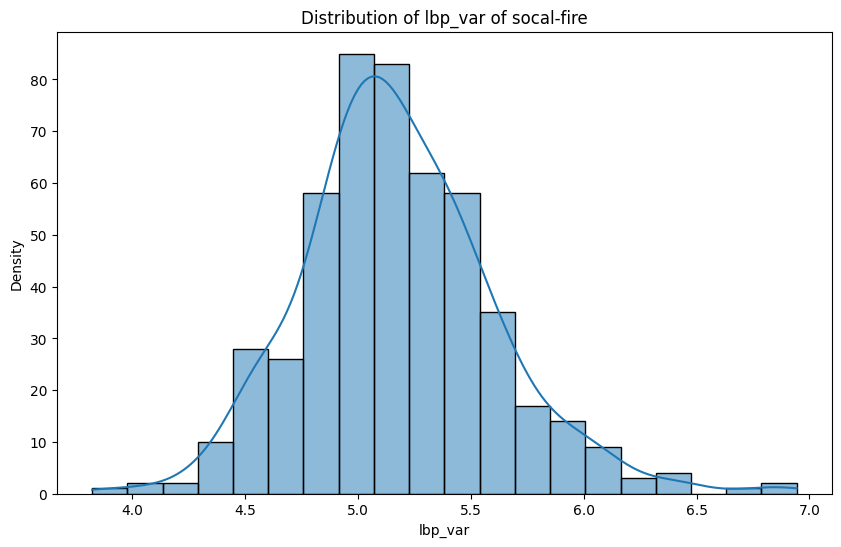

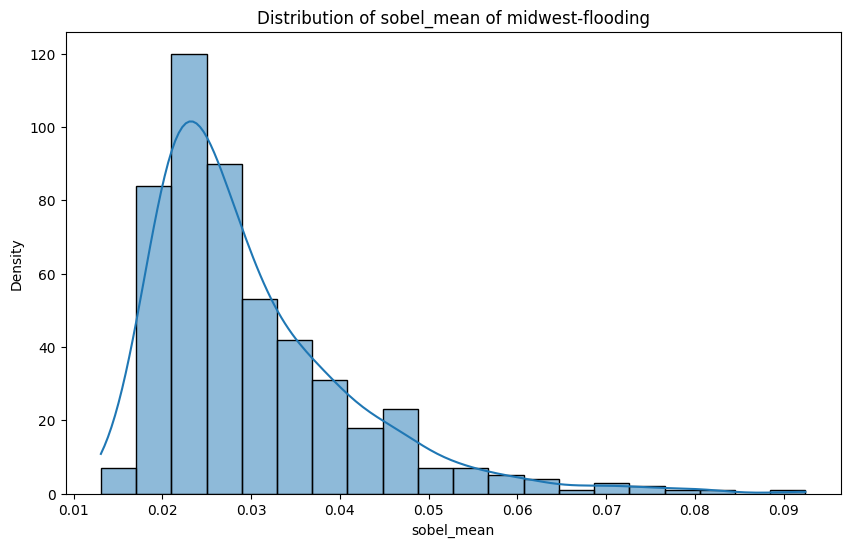

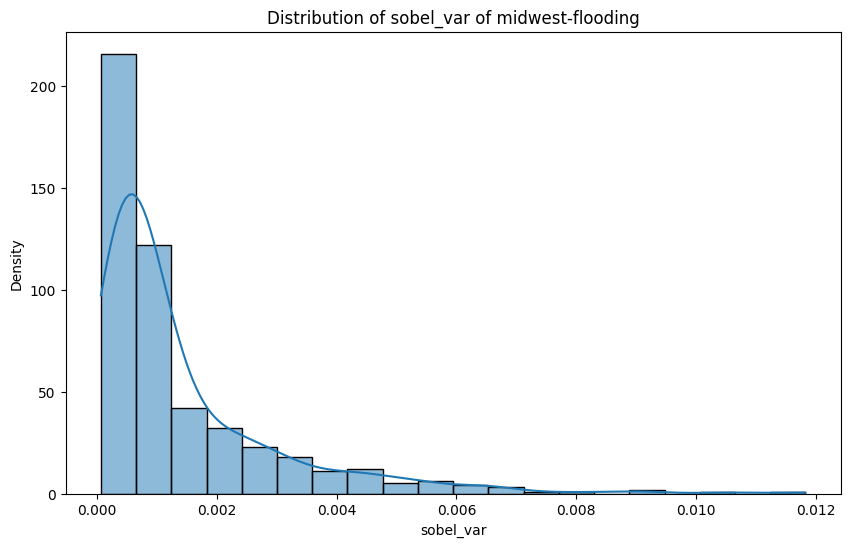

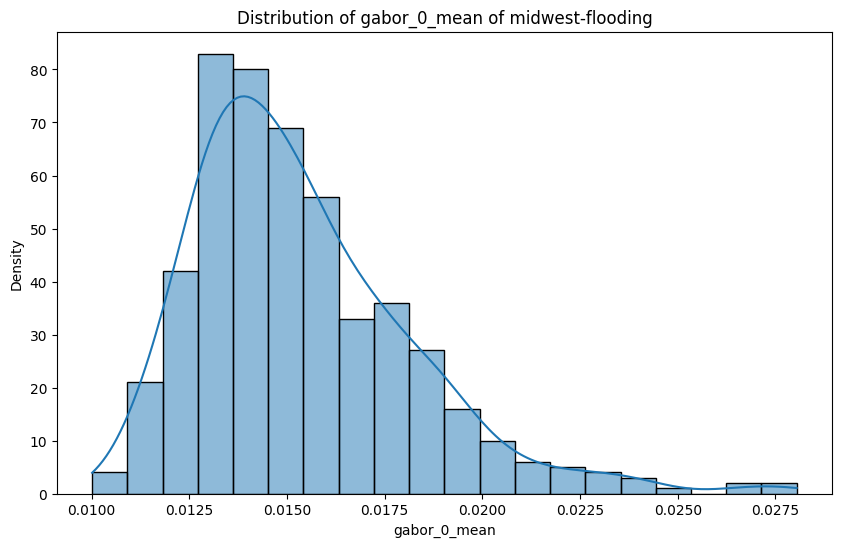

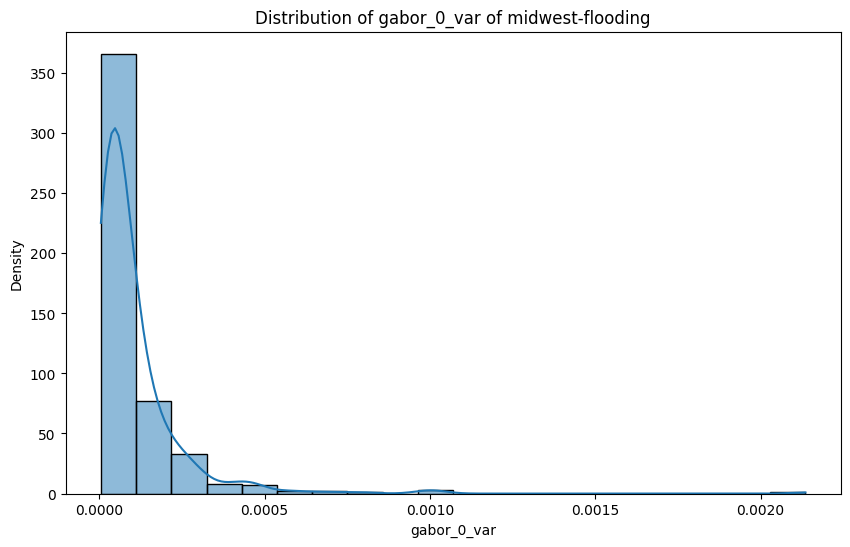

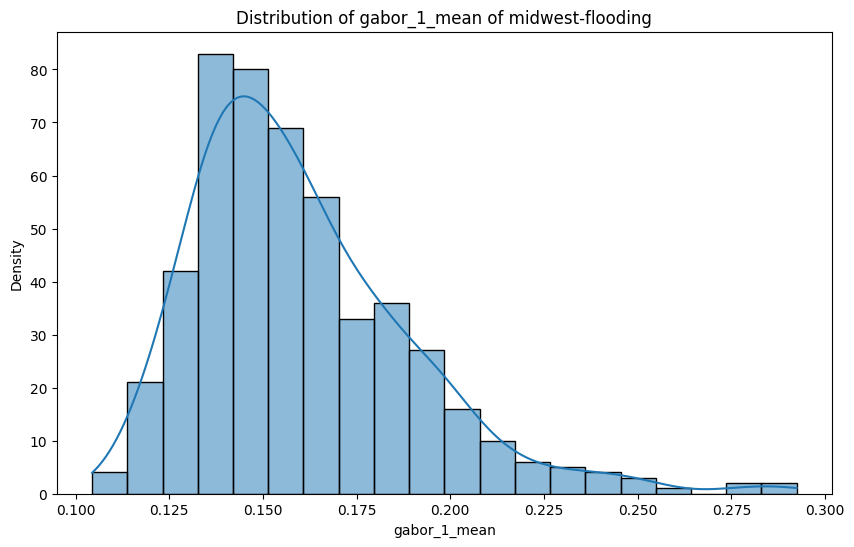

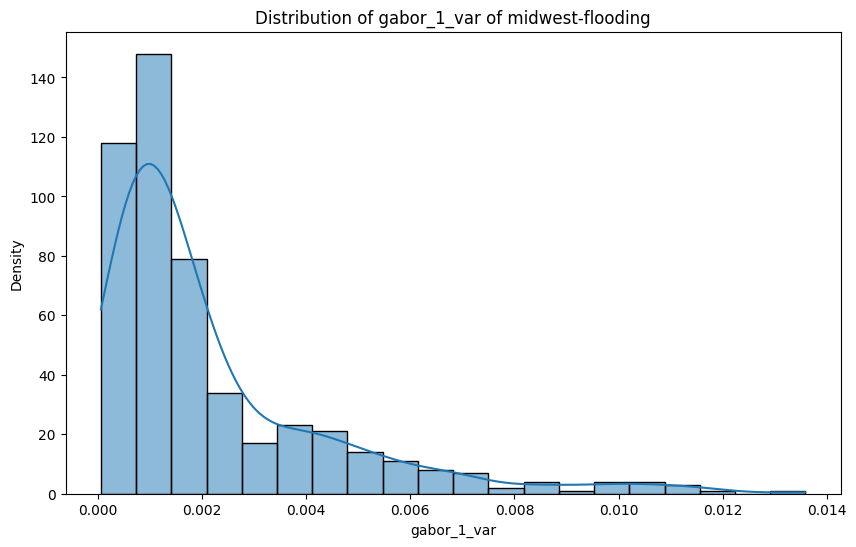

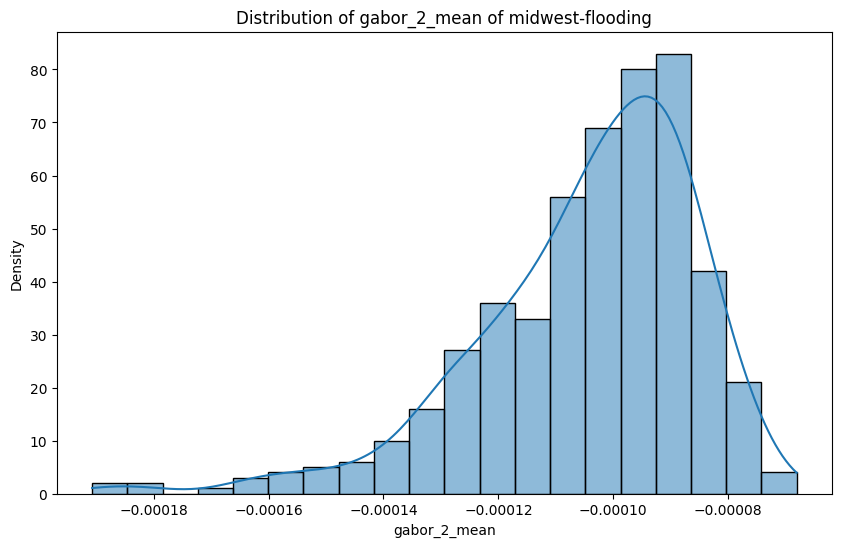

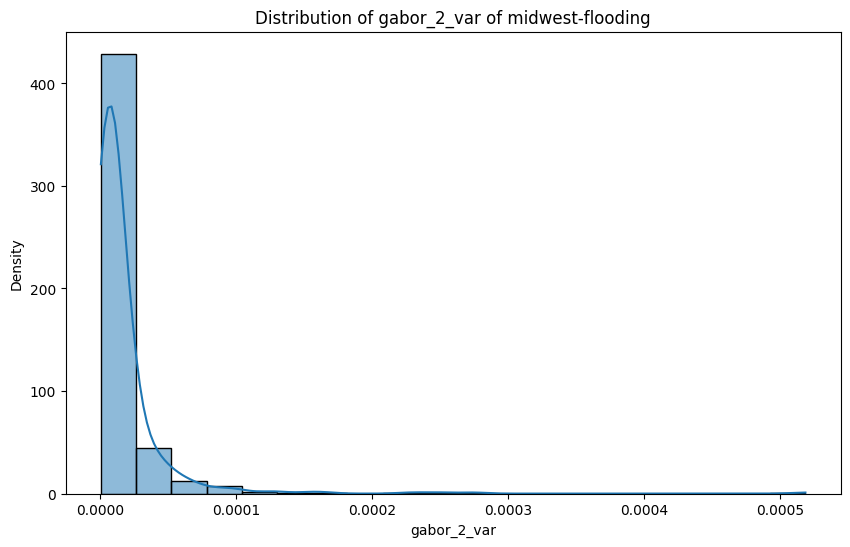

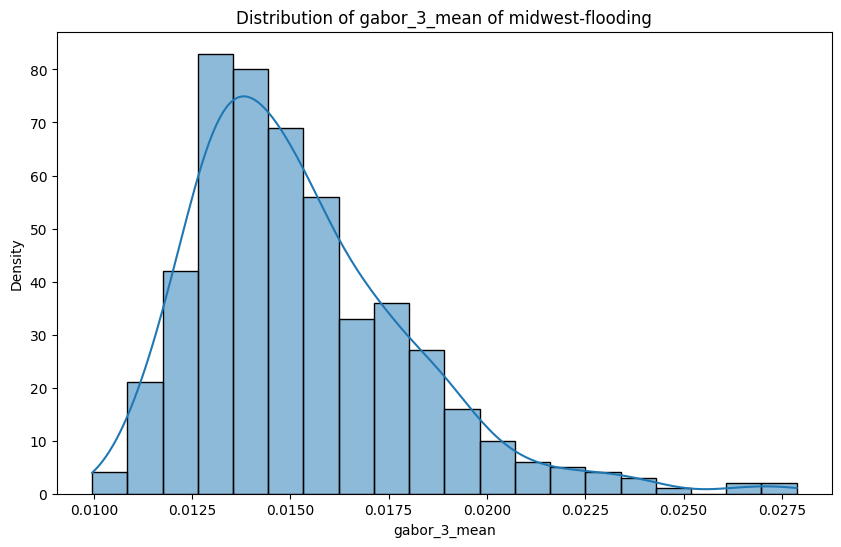

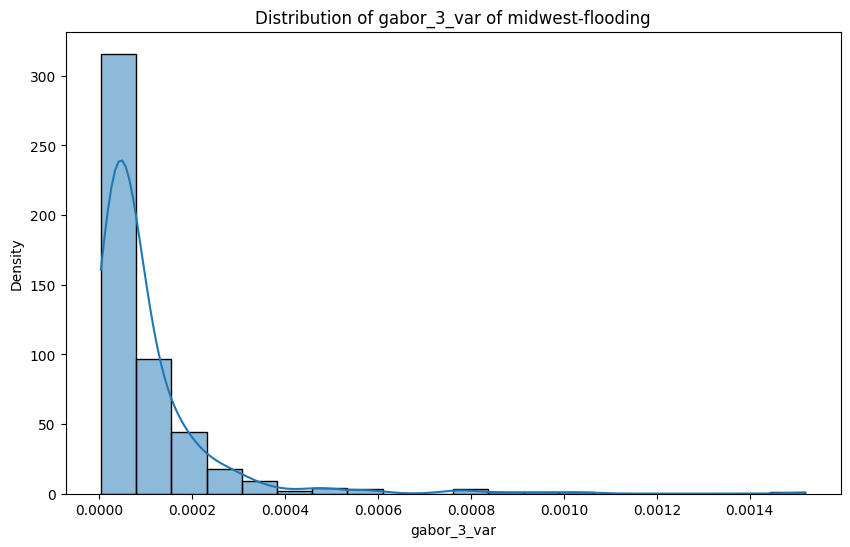

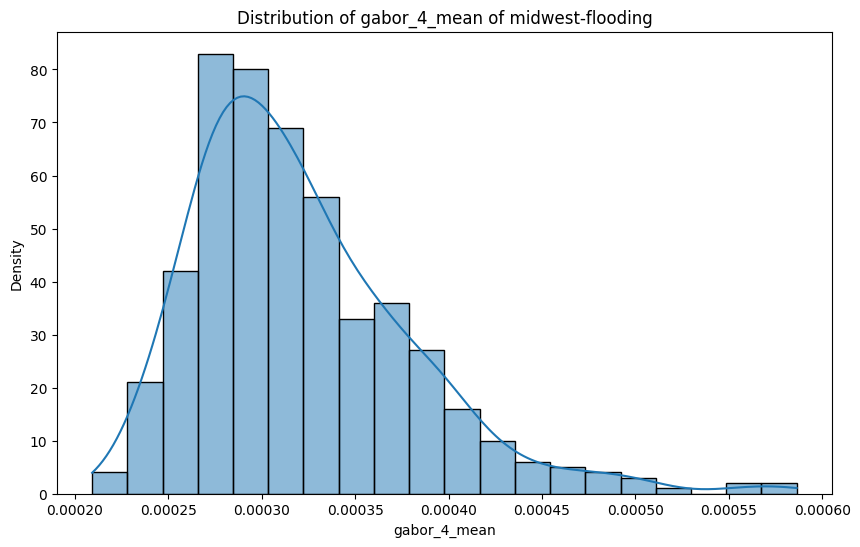

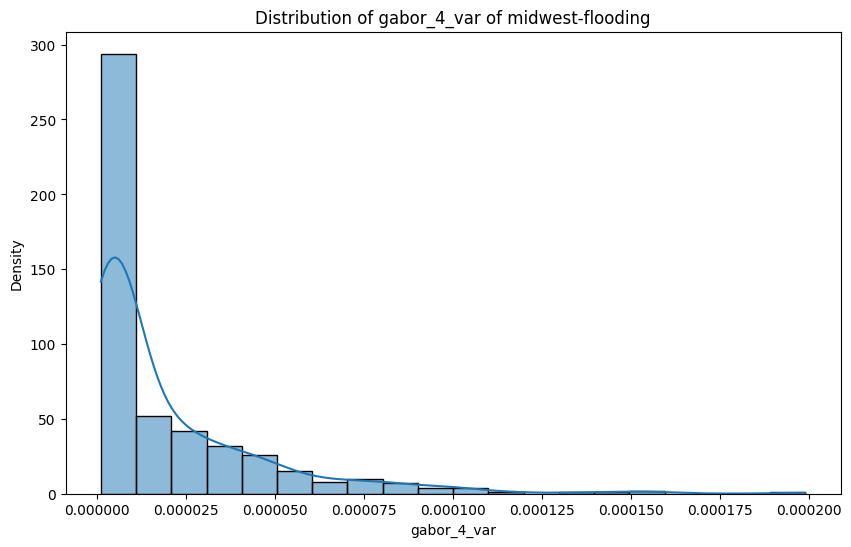

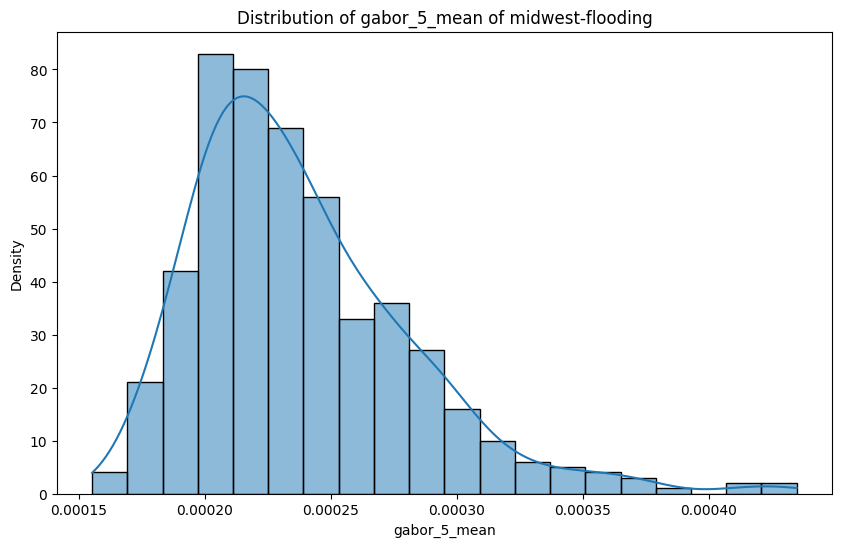

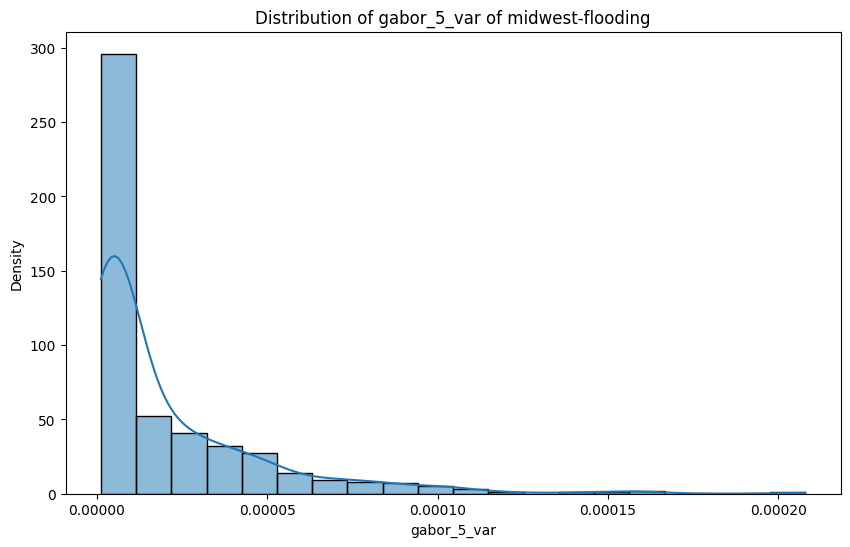

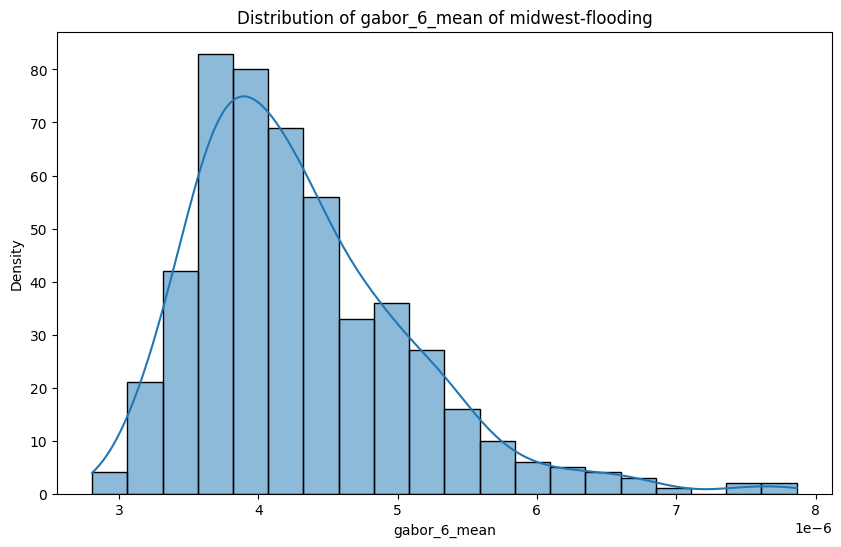

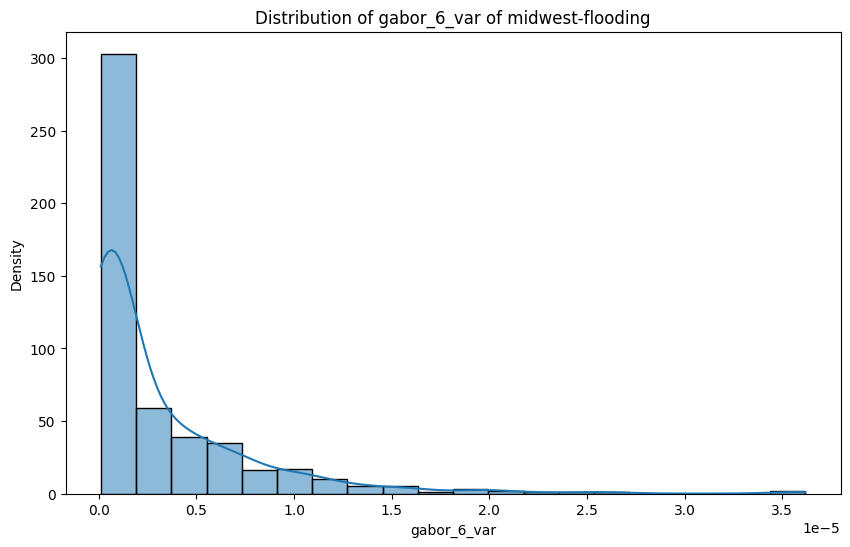

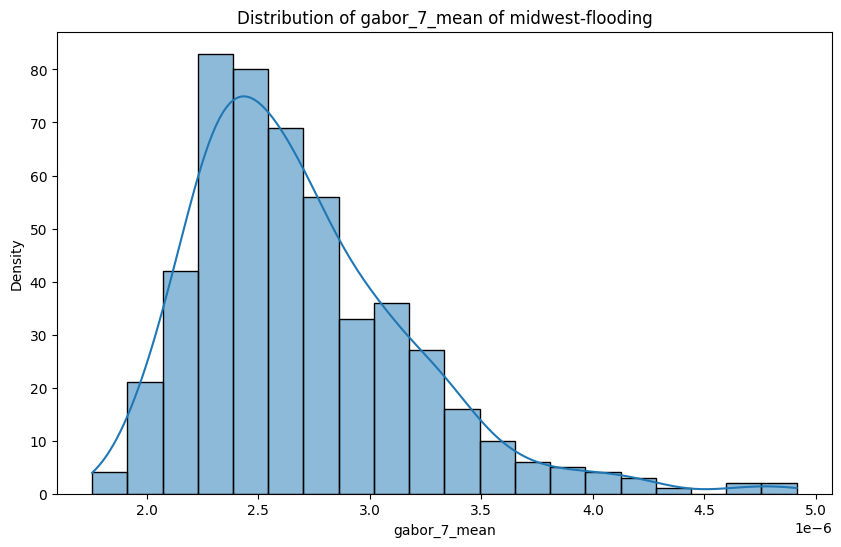

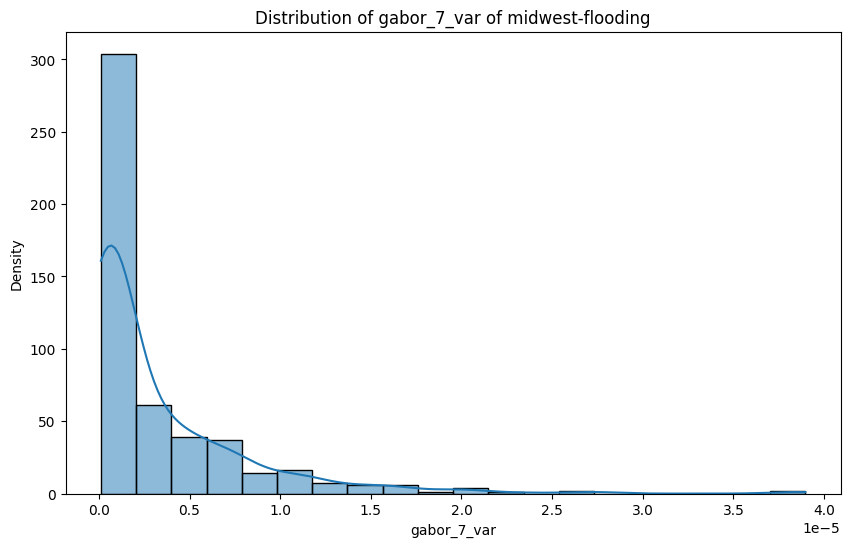

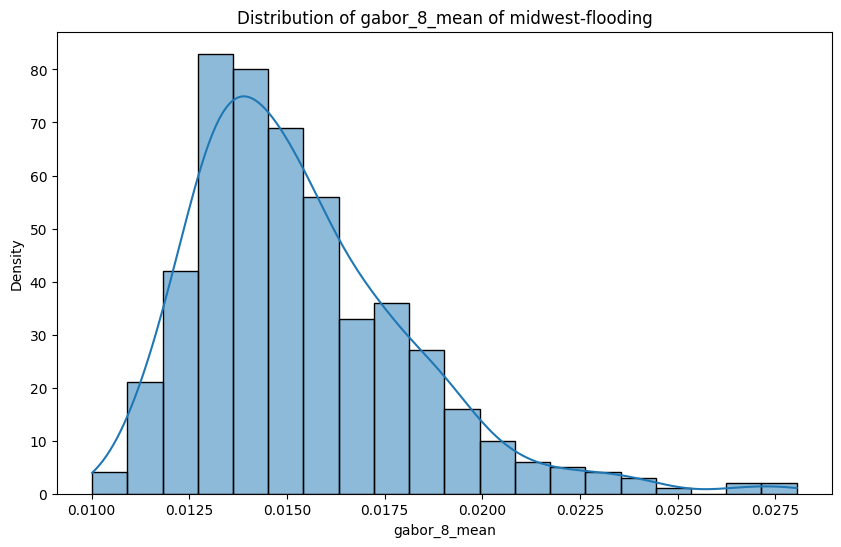

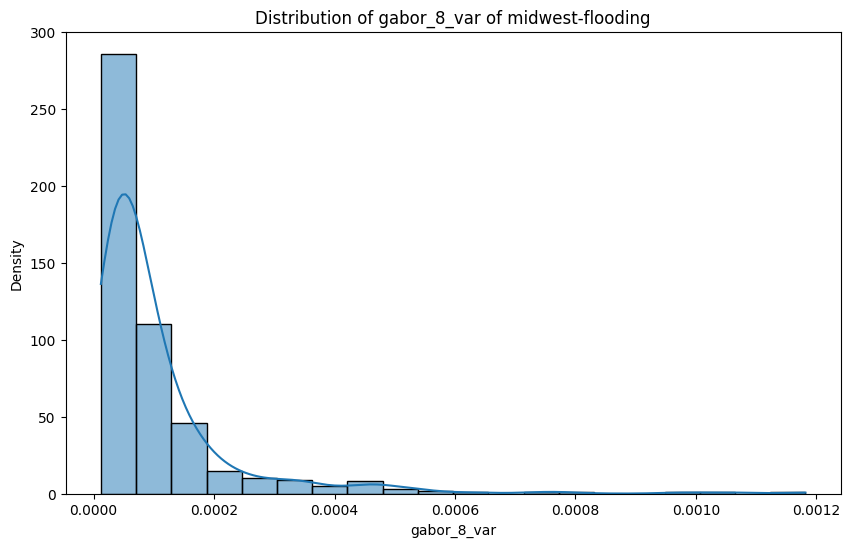

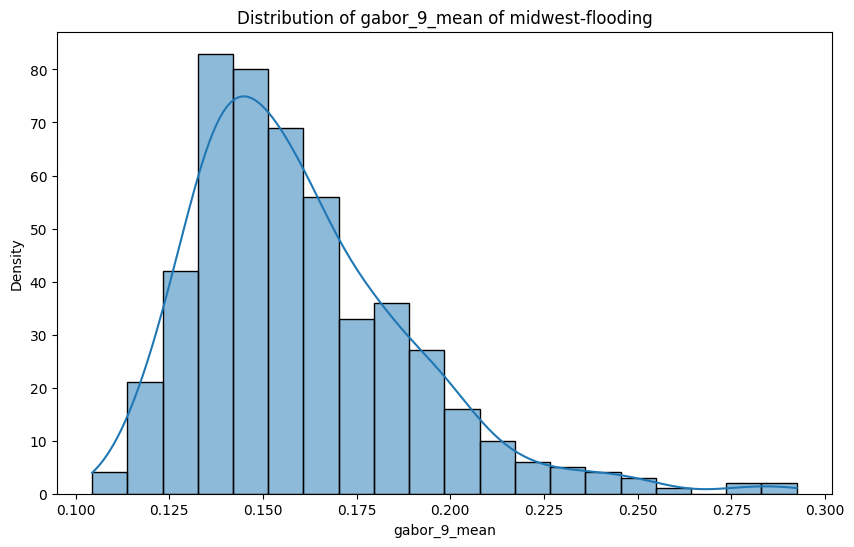

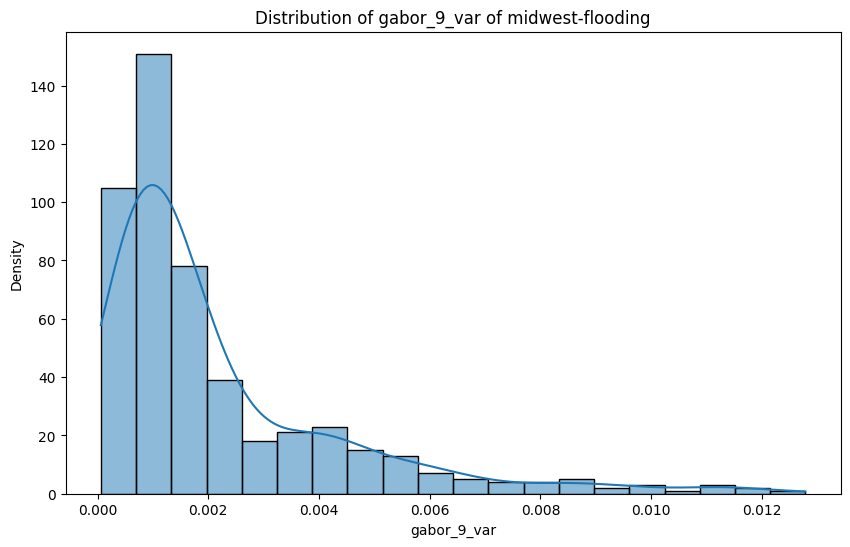

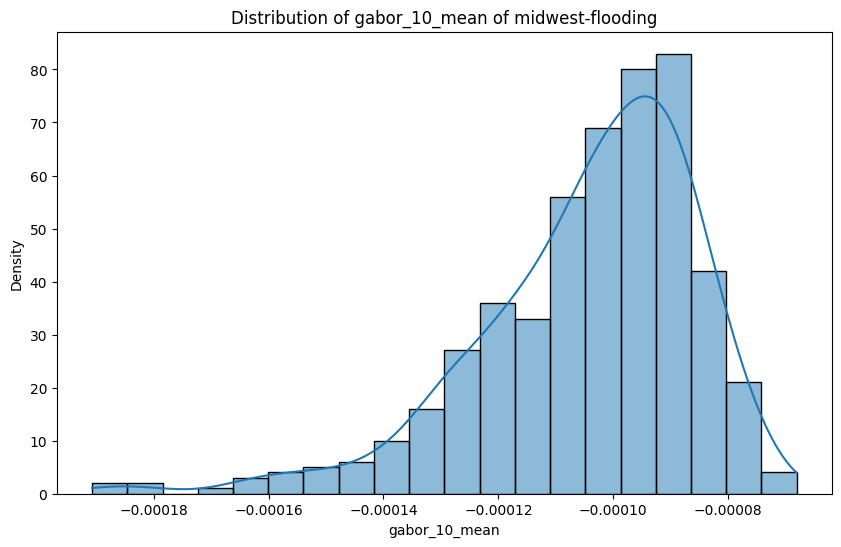

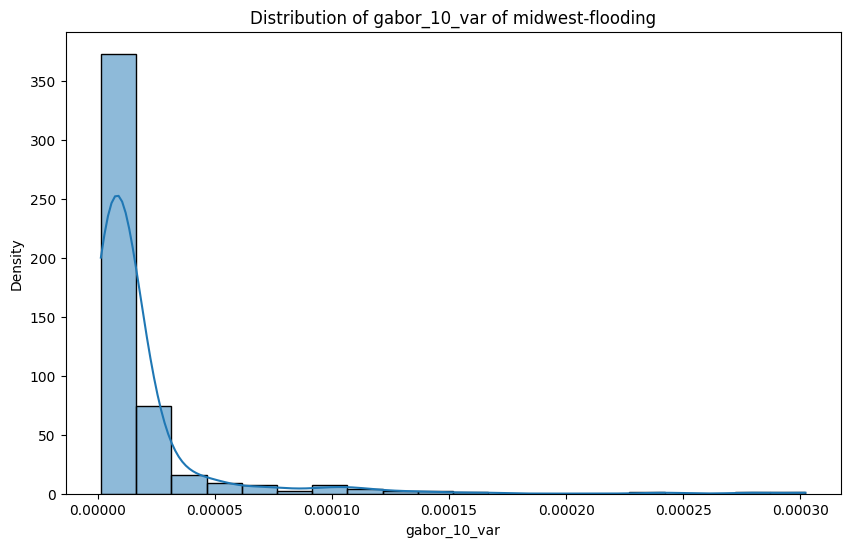

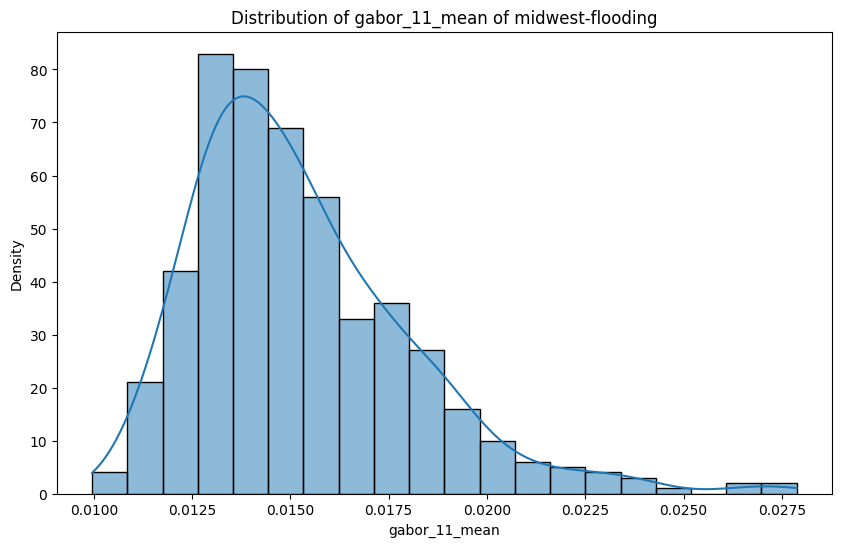

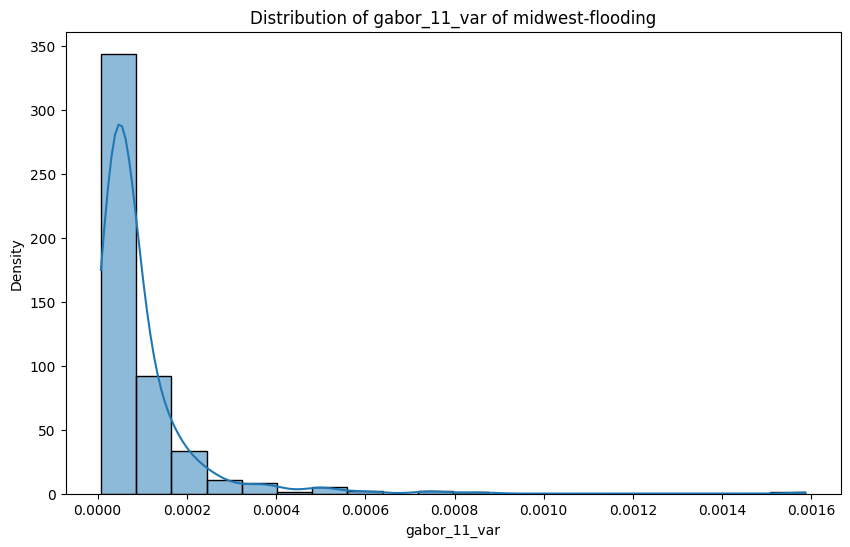

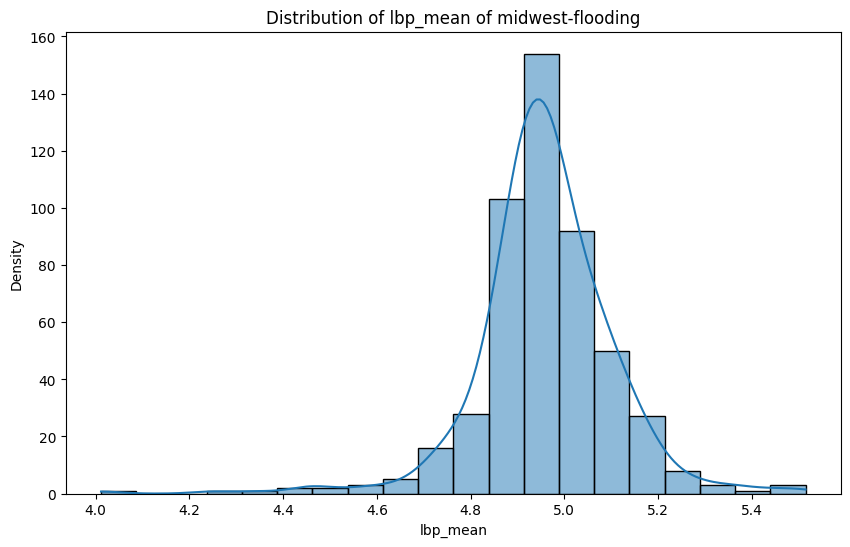

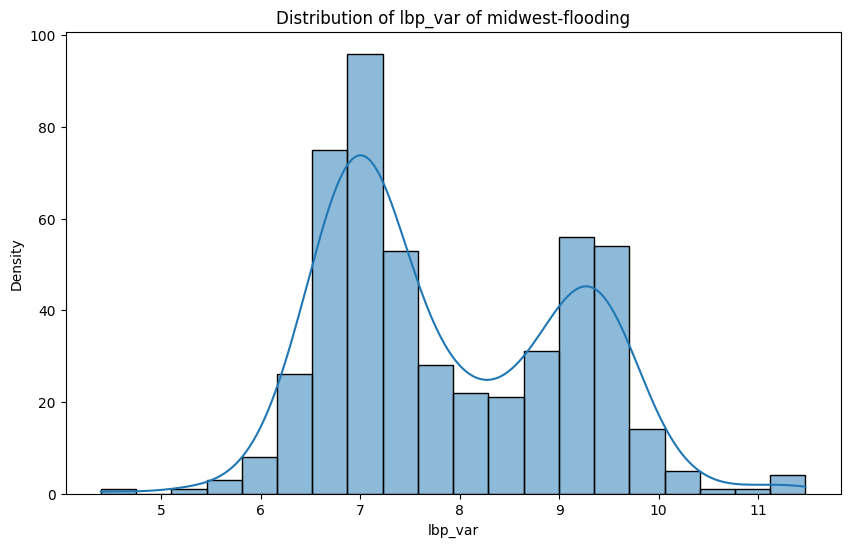

In [12]:
# TASK A: DISASTER TYPE CLASSIFICATION

task_a_list = ['socal-fire', 'midwest-flooding']

# Define Gabor kernel parameters
theta_vals = [0, np.pi/4, np.pi/2]
sigma_vals = [1, 2]
frequency_vals = [0.6, 0.8]

# Generate Gabor kernels
gabor_kernels = generate_gabor_kernels(theta_vals, sigma_vals, frequency_vals)

# Process each dataset and extract features into a DataFrame
all_datasets_features = {}
for disaster in task_a_list:
    disaster_img_dataset = data[disaster]['images']

    # Take a random sample of the image dataset
    sampled_indices = np.random.choice(range(len(disaster_img_dataset)), size=min(num_samples, len(disaster_img_dataset)), replace=False)
    sampled_images = [disaster_img_dataset[i] for i in sampled_indices]

    image_feature_dicts = [extract_combined_features(img, gabor_kernels) for img in sampled_images]
    all_datasets_features[disaster] = pd.DataFrame(image_feature_dicts)

# Visualize feature distributions for each dataset
for disaster, feature_df in all_datasets_features.items():
    visualize_feature_distribution(feature_df, disaster)

**Training a Random Forest Classifier model on these extracted features:**


In [13]:
## THIS TAKES 8-9 MINUTES

# Use the same gabor kernels from previous cell and extract the features for full task a dataset
# Placeholder lists for features and labels
features_list = []
labels_list = []

# Process each dataset and extract features
for disaster in task_a_list:
    disaster_img_dataset = data[disaster]['images']

    # Extract features from sampled images
    for img in disaster_img_dataset:
        features = extract_combined_features(img, gabor_kernels)
        features_list.append(features)
        labels_list.append(disaster)  # Append the disaster name as the label

# Create a DataFrame with all features and corresponding labels
feature_df = pd.DataFrame(features_list)
feature_df['label'] = labels_list  # Add the labels as a new column
print(feature_df)

       sobel_mean  sobel_var  gabor_0_mean  gabor_0_var  gabor_1_mean  \
0        0.048752   0.002715      0.021613     0.000109      0.225385   
1        0.046197   0.001996      0.014598     0.000094      0.152225   
2        0.043064   0.002014      0.019877     0.000098      0.207281   
3        0.044347   0.001629      0.018677     0.000089      0.194762   
4        0.037459   0.001431      0.016642     0.000097      0.173548   
...           ...        ...           ...          ...           ...   
15379    0.024533   0.000594      0.018899     0.000279      0.197075   
15380    0.033180   0.001557      0.020277     0.000159      0.211448   
15381    0.024502   0.000415      0.014317     0.000051      0.149299   
15382    0.021576   0.000477      0.011747     0.000024      0.122502   
15383    0.021742   0.000343      0.013106     0.000019      0.136664   

       gabor_1_var  gabor_2_mean  gabor_2_var  gabor_3_mean  gabor_3_var  ...  \
0         0.006954     -0.000147     0.000

In [14]:
# Encode labels to binary format
le = LabelEncoder()
binary_labels = le.fit_transform(feature_df['label'])  # Converts 'socal-fire' to 0 and 'midwest-flooding' to 1

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df.iloc[:,:-1])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, binary_labels, test_size=0.2, random_state=42)

Accuracy: 0.9827754306142347
                  precision    recall  f1-score   support

midwest-flooding       0.98      0.98      0.98      1404
      socal-fire       0.98      0.99      0.98      1673

        accuracy                           0.98      3077
       macro avg       0.98      0.98      0.98      3077
    weighted avg       0.98      0.98      0.98      3077



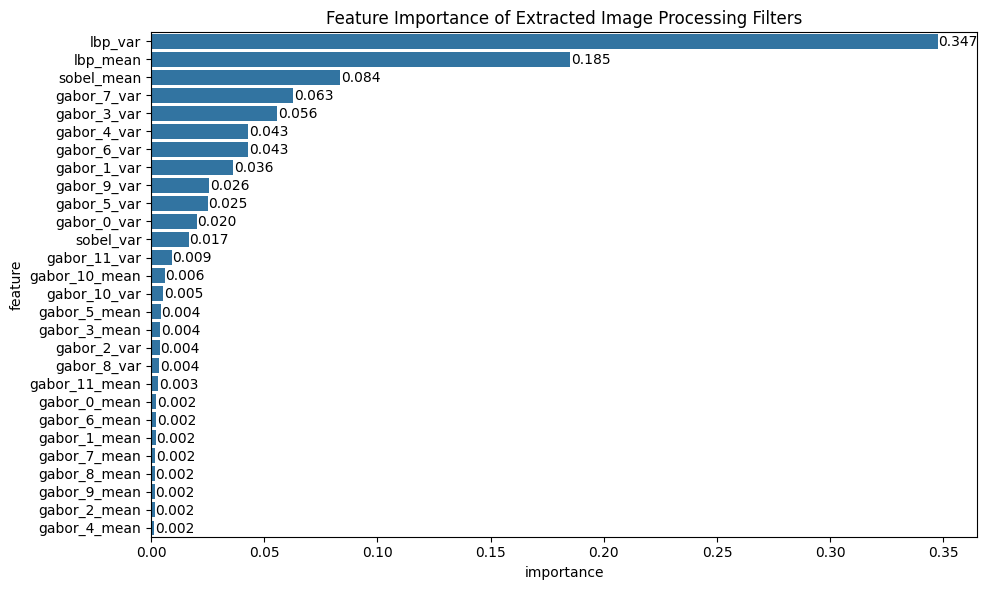

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': feature_df.columns[:-1],
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.675))
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()

**Initializing a dictionary containing each disaster's dataframe, containing features that may be relevant in the downstream training of our model:**


In [16]:
# SHOULD ONLY BE RAN ONCE
df = {}
for disaster in disaster_list:
  df[disaster] = pd.DataFrame(pd.Series(data[disaster]['images'])).rename({0:'image_matrix'}, axis=1)
  df[disaster]['disaster'] = f'{disaster}'
  df[disaster]['label'] = pd.Series(data[disaster]['labels'])
  df[disaster]['height'] = pd.Series(heights[disaster])
  df[disaster]['width'] = pd.Series(widths[disaster])
  df[disaster]['aspect_ratio'] = df[disaster]['width'] / df[disaster]['height']
  df[disaster]['total_pixels'] = df[disaster]['height'] * df[disaster]['width']
  df[disaster]['avg_pixel_int'] = df[disaster]['image_matrix'].apply(np.mean)

**Assigning each dataframe to their respective tasks and exporting them as '.csv' files for easier importing later on:**


In [17]:
# Run this to generate dataframes for task modeling

important_features = ['lbp_var', 'lbp_mean', 'sobel_mean', 'gabor_7_var', 'gabor_3_var'] # Image processing features with importance > 0.05
task_1_df = pd.concat([df['socal-fire'], df['midwest-flooding']], ignore_index=True)
for feature in important_features:
  task_1_df[feature] = feature_df[feature]
assert(task_1_df.shape[0] == 8380+7004)
assert(task_1_df.shape[1] == 13)

print('Top 3 rows from `task_1_df`')
display(task_1_df.head(3))

task_2_df = df['hurricane-matthew']
assert(task_2_df.shape[0] == 11151)

print('\nTop 3 rows from `task_2_df`')
display(task_2_df.head(3))

Top 3 rows from `task_1_df`


,image_matrix,disaster,label,height,width,aspect_ratio,total_pixels,avg_pixel_int,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var
0,"[[[50, 72, 48], [49, 71, 47], [49, 71, 48], [4...",socal-fire,0,144,195,1.354167,28080,122.675415,4.963108,4.652137,0.048752,3.979585e-07,0.000144
1,"[[[66, 84, 80], [79, 99, 94], [103, 127, 120],...",socal-fire,0,48,51,1.062500,2448,82.526416,5.270881,4.534314,0.046197,4.679938e-07,0.000121
2,"[[[74, 107, 95], [74, 106, 95], [70, 100, 91],...",socal-fire,0,104,140,1.346154,14560,110.527908,4.821204,4.668475,0.043064,2.617666e-07,0.000152



Top 3 rows from `task_2_df`


,image_matrix,disaster,label,height,width,aspect_ratio,total_pixels,avg_pixel_int
0,"[[[58, 94, 83], [60, 97, 86], [61, 98, 86], [6...",hurricane-matthew,3,65,54,0.830769,3510,94.020703
1,"[[[150, 177, 183], [147, 174, 182], [153, 180,...",hurricane-matthew,0,67,105,1.567164,7035,106.040938
2,"[[[59, 81, 75], [53, 75, 69], [47, 68, 62], [5...",hurricane-matthew,1,54,56,1.037037,3024,117.725198


**Verifying that our dataframes don't have any `NaN` values:**


In [18]:
assert(task_1_df.isna().any().all() == False)
assert(task_2_df.isna().any().all() == False)

**Looking at one `hurricane-matthew` image under different color channels and filters:**


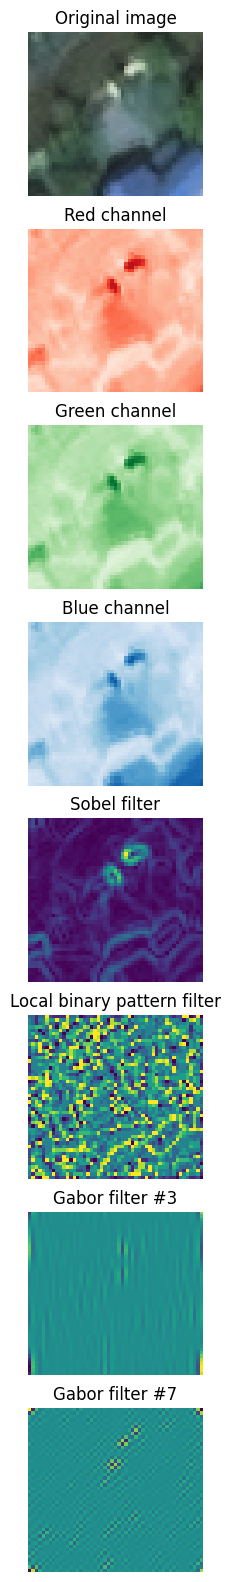

In [19]:
plt.figure(figsize=(20,20))

plt.subplot(8, 1, 1)
plt.imshow(task_1_df['image_matrix'][1])
plt.title("Original image")
plt.axis("off")

plt.subplot(8, 1, 2)
plt.imshow(task_1_df['image_matrix'][1][:,:,0], cmap="Reds", vmin=0, vmax=255)
plt.title("Red channel")
plt.axis("off")

plt.subplot(8, 1, 3)
plt.imshow(task_1_df['image_matrix'][1][:,:,1], cmap="Greens", vmin=0, vmax=255)
plt.title("Green channel")
plt.axis("off")

plt.subplot(8, 1, 4)
plt.imshow(task_1_df['image_matrix'][1][:,:,2], cmap="Blues", vmin=0, vmax=255)
plt.title("Blue channel")
plt.axis("off")

plt.subplot(8, 1, 5)
plt.imshow(get_sobel_features(task_1_df['image_matrix'][1]))
plt.title("Sobel filter")
plt.axis("off")

plt.subplot(8, 1, 6)
plt.imshow(get_local_binary_pattern(task_1_df['image_matrix'][1]))
plt.title("Local binary pattern filter")
plt.axis("off")

kernel_3 = generate_gabor_kernel(frequency=0.6, theta=0, sigma=2)
plt.subplot(8, 1, 7)
plt.imshow(get_gabor_features(task_1_df['image_matrix'][1], kernel_3))
plt.title("Gabor filter #3")
plt.axis("off")

kernel_7 = generate_gabor_kernel(frequency=0.6, theta=np.pi/4, sigma=2)
plt.subplot(8, 1, 8)
plt.imshow(get_gabor_features(task_1_df['image_matrix'][1], kernel_7))
plt.title("Gabor filter #7")
plt.axis("off")

plt.show()

**Exploring each dataframe through `.groupby()` operations to find potential features of interest:**

From the first 'groupby' operation, we can see that the `socal-fire` images have, on average, higher total pixels and pixel intensities than the `midwest-flooding` images. This corroborates the conclusion drawn from the color channel intensity histograms, which showed that the mean intensities of pixels across all three channels were higher, which may be something to consider when training our first model.

The `hurricane-matthew` dataframe has less obvious features to draw from, besides mean total pixels. Further EDA will be conducted to properly draw features from these images.


In [20]:
print("Grouping `task_1_df` by disaster:")
by_disaster = task_1_df.groupby('disaster').mean(numeric_only=True).drop('label', axis=1)
display(by_disaster)

print("\nGrouping `task_2_df` by label:")
by_label = task_2_df.groupby('label').mean(numeric_only=True)
display(by_label)

Grouping `task_1_df` by disaster:


,height,width,aspect_ratio,total_pixels,avg_pixel_int,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var
disaster,,,,,,,,,,
midwest-flooding,82.353798,84.223587,1.185343,8552.915762,84.703778,7.838181,4.961290,0.030281,3.334399e-06,0.000099
socal-fire,99.801074,101.391527,1.153420,12742.040215,102.577726,5.202468,4.634897,0.045409,4.024466e-07,0.000172



Grouping `task_2_df` by label:


,height,width,aspect_ratio,total_pixels,avg_pixel_int
label,,,,,
0,59.269479,59.700494,1.112572,4313.262258,98.637923
1,64.870894,66.505348,1.098256,5234.814171,101.180972
2,63.480570,64.694948,1.116007,4779.865285,100.494853
3,43.938506,46.233908,1.096346,2279.792529,96.365045


**Plotting data from the `.groupby()` operations:**


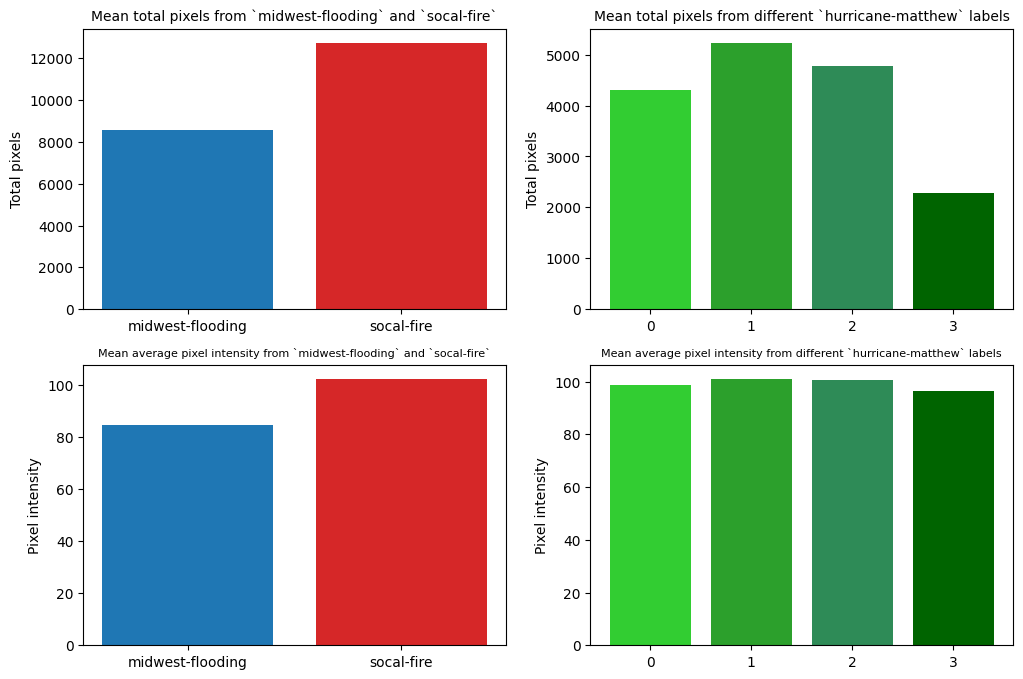

In [21]:
fig, axs = plt.subplots(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(x=by_disaster.index,
        height=by_disaster['total_pixels'],
        color=['tab:blue','tab:red'])
plt.ylabel("Total pixels")
plt.title("Mean total pixels from `midwest-flooding` and `socal-fire`", fontsize=10)

plt.subplot(2, 2, 2)
plt.bar(x=by_label.index.astype('str'),
        height=by_label['total_pixels'],
        color=['limegreen', 'tab:green', 'seagreen', 'darkgreen'])
plt.ylabel("Total pixels")
plt.title("Mean total pixels from different `hurricane-matthew` labels", fontsize=10)

plt.subplot(2, 2, 3)
plt.bar(x=by_disaster.index,
        height=by_disaster['avg_pixel_int'],
        color=['tab:blue','tab:red'])
plt.ylabel("Pixel intensity")
plt.title("Mean average pixel intensity from `midwest-flooding` and `socal-fire`", fontsize=8)

plt.subplot(2, 2, 4)
plt.bar(x=by_label.index.astype('str'),
        height=by_label['avg_pixel_int'],
        color=['limegreen', 'tab:green', 'seagreen', 'darkgreen'])
plt.ylabel("Pixel intensity")
plt.title("Mean average pixel intensity from different `hurricane-matthew` labels", fontsize=8)

plt.show()

**Defining a function to calculate the percent coverage of pixels that cross a certain intensity threshold:**


In [22]:
def color_coverage(image, area, rgb, threshold=150):
  """
  This function finds the percent coverage of pixels that reach a defined threshold
  of intensity for a given color channel.

  Args:
        image (ndarray): Numpy array representation of an image.
        area (int): Total pixel area of an image.
        rgb (int): Integer representing the color channel (0 for red, 1 for green, 2 for blue).
        threshold (float): The threshold intensity of pixels.

    Returns:
        percent_color (float): The percentage of pixels in an image that cross the threshold intensity.
  """
  pixel_count = (image['image_matrix'][:,:,rgb] >= threshold).sum()
  percent_color = pixel_count / area
  return percent_color

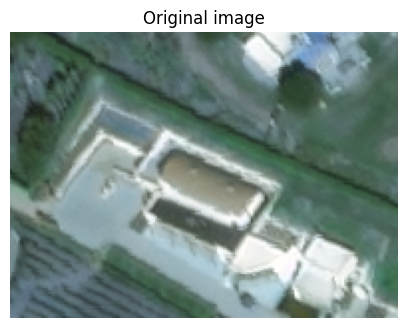

About 23.5% of red pixels met the threshold in the above image.
About 31.0% of green pixels met the threshold in the above image.
About 30.0% of blue pixels met the threshold in the above image.


In [23]:
# determines the threshold of the channel intensity to be included in the area count
threshold = 150
colors_dict = {'red':0,'green':1,'blue':2}

plt.figure(figsize=(5,5))

plt.imshow(task_1_df['image_matrix'][0])
plt.title("Original image")
plt.axis("off")
plt.show()

for color in colors_dict.keys():
  #select image matrix & area
  fire_img = task_1_df.iloc[0]
  fire_img_size = task_1_df['total_pixels'][0]

  percent = color_coverage(fire_img,fire_img_size,colors_dict[color])
  print(f'About {percent.round(3)*100}% of {color} pixels met the threshold in the above image.')

**Appending a new feature to the Task 1 dataframe using the `color_coverage()` function:**


In [24]:
threshold = 150
for color in colors_dict.keys():
  col_name = f"area of {color} pixels at {threshold} threshold"
  task_1_df[col_name] = task_1_df.apply(lambda x: color_coverage(x,x['total_pixels'],colors_dict[color],threshold),axis=1)
task_1_df.head(3)

,image_matrix,disaster,label,height,width,aspect_ratio,total_pixels,avg_pixel_int,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var,area of red pixels at 150 threshold,area of green pixels at 150 threshold,area of blue pixels at 150 threshold
0,"[[[50, 72, 48], [49, 71, 47], [49, 71, 48], [4...",socal-fire,0,144,195,1.354167,28080,122.675415,4.963108,4.652137,0.048752,3.979585e-07,0.000144,0.235399,0.310043,0.300214
1,"[[[66, 84, 80], [79, 99, 94], [103, 127, 120],...",socal-fire,0,48,51,1.062500,2448,82.526416,5.270881,4.534314,0.046197,4.679938e-07,0.000121,0.010621,0.017157,0.075163
2,"[[[74, 107, 95], [74, 106, 95], [70, 100, 91],...",socal-fire,0,104,140,1.346154,14560,110.527908,4.821204,4.668475,0.043064,2.617666e-07,0.000152,0.098420,0.171429,0.151580


**Plotting the difference in percent coverage of `socal-fire` images by the different labels:**


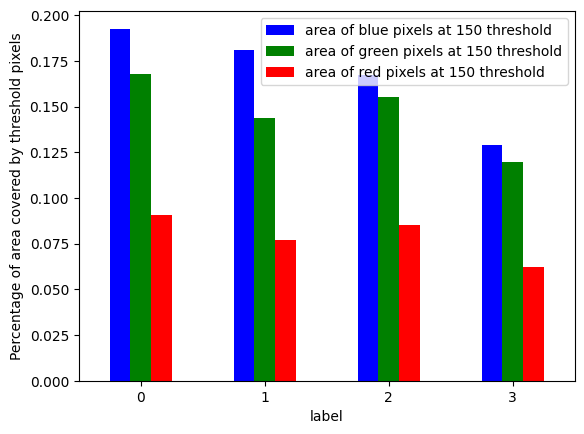

In [25]:
#selects only fires
fires = task_1_df[task_1_df['disaster'] == 'socal-fire']
#labels & color fractions
fires_colors = fires.iloc[:,[2,-1,-2,-3]]

#groupby label and calculate mean
fires_grouped = fires_colors.groupby('label').agg('mean')

fires_grouped.plot(kind='bar',rot='horizontal',ylabel='Percentage of area covered by threshold pixels', color=['b','g','r'])

plt.legend()

plt.show()

**Saving `task_1_df` as a `.csv` file for easier importing later on:**


In [49]:
task_1_df.to_csv('../data/task-data/task-1.csv', index=False)

# Modeling - Task A: `midwest-flooding` vs. `socal-fire`


The model we'll be using to complete Task A and B are support vector machines (SVMs), specifically `sklearn`'s `LinearSVC` model, which is suited for both binary (Task A) and multi-class classification (Task B).


**Importing `LinearSVC` from `sklearn`:**


In [26]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [27]:
task_1_df = pd.read_csv('../data/task-data/task-1.csv')
task_1_df.head()

,image_matrix,disaster,label,height,width,aspect_ratio,total_pixels,avg_pixel_int,lbp_var,lbp_mean,sobel_mean,gabor_7_var,gabor_3_var,area of red pixels at 150 threshold,area of green pixels at 150 threshold,area of blue pixels at 150 threshold
0,[[[ 50 72 48]\r\n [ 49 71 47]\r\n [ 49 ...,socal-fire,0,144,195,1.354167,28080,122.675415,4.963108,4.652137,0.048752,3.979585e-07,0.000144,0.235399,0.310043,0.300214
1,[[[ 66 84 80]\r\n [ 79 99 94]\r\n [103 1...,socal-fire,0,48,51,1.062500,2448,82.526416,5.270881,4.534314,0.046197,4.679938e-07,0.000121,0.010621,0.017157,0.075163
2,[[[ 74 107 95]\r\n [ 74 106 95]\r\n [ 70 1...,socal-fire,0,104,140,1.346154,14560,110.527908,4.821204,4.668475,0.043064,2.617666e-07,0.000152,0.098420,0.171429,0.151580
3,[[[100 114 111]\r\n [102 115 112]\r\n [105 1...,socal-fire,0,128,138,1.078125,17664,105.995131,4.830619,4.610054,0.044347,2.846567e-07,0.000125,0.067652,0.125170,0.125566
4,[[[ 67 100 90]\r\n [ 65 98 88]\r\n [ 60 ...,socal-fire,0,65,96,1.476923,6240,93.071047,5.323417,4.728526,0.037459,2.879416e-07,0.000151,0.027404,0.054487,0.114263


In [28]:
X = task_1_df.iloc[:, 2:]
y = task_1_df['disaster'].replace({'midwest-flooding' : 0,
                                 'socal-fire' : 1})
assert(len(X) == 8380+7004)
assert(len(y) == 8380+7004)
print(X.shape, y.shape)

(15384, 14) (15384,)


In [29]:
# LinearSVC Feature Selection (runtime: ~8sec)
def svc_feature_selection(features):
  feature_scores = []

  for combo in features:
    X_train, X_val, y_train, y_val = train_test_split(X[combo], y, test_size=0.2, random_state=42)
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
    feature_scores.append((combo, pipe.fit(X_train, y_train).score(X_train, y_train)))

  return feature_scores

feature_combinations = [['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']]

print(f'Best training score among feature combinations: {max(svc_feature_selection(feature_combinations))[1]:.3f}')

svc_best_params = max(svc_feature_selection(feature_combinations))[0]
print(f'Best parameters for LinearSVC: {svc_best_params}')

Best training score among feature combinations: 0.982
Best parameters for LinearSVC: ['lbp_var', 'lbp_mean', 'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']


In [30]:
# LinearSVC Grid Search (runtime: ~1min 20sec)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('scaler', StandardScaler()),
                 ('svc', LinearSVC())])

param_grid = {'svc__C' : [0.01, 0.1, 1, 10, 100],
              'svc__max_iter' : [500, 1000, 2000, 3000],
              'svc__penalty' : ['l1', 'l2']}

best_X = X[svc_best_params]

grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(best_X, y)

print(f'Best score: {grid_search.best_score_:.3f}')
print(f'Best hyperparameters for LinearSVC model: {grid_search.best_params_}')

Best score: 0.982
Best hyperparameters for LinearSVC model: {'svc__C': 10, 'svc__max_iter': 500, 'svc__penalty': 'l2'}


The only hyperparameters we'll have to tune are C, or the regularization parameter, and the max iterations. The default values for each are 1.0 and 1000, will be tuned to 10 and 500.


In [49]:
optimal_pipe = Pipeline([('scaler', StandardScaler()),
                         ('svc', LinearSVC(C=10, max_iter=1000))]) # default penalty is 'l2'

X_train, X_val, y_train, y_val = train_test_split(best_X, y, test_size=0.2, random_state=42)
optimal_pipe.fit(X_train, y_train)
svc_train_preds = optimal_pipe.predict(X_train)
svc_train_score = optimal_pipe.score(X_train, y_train)
svc_val_preds = optimal_pipe.predict(X_val)
svc_val_score = optimal_pipe.score(X_val, y_val)
svc_cv_score = cross_val_score(optimal_pipe, best_X, y, cv=10)
print(f'Initial training score: {svc_train_score}')
print(f'Initial validation score: {svc_val_score}')
print(f'Average cross-validation score across 10 folds: {svc_cv_score.mean()}')

Initial training score: 0.98196148533355
Initial validation score: 0.9814754631134222
Average cross-validation score across 10 folds: 0.9818639516481324


              precision    recall  f1-score   support

           0      0.984     0.975     0.980      1404
           1      0.979     0.987     0.983      1673

    accuracy                          0.981      3077
   macro avg      0.982     0.981     0.981      3077
weighted avg      0.981     0.981     0.981      3077



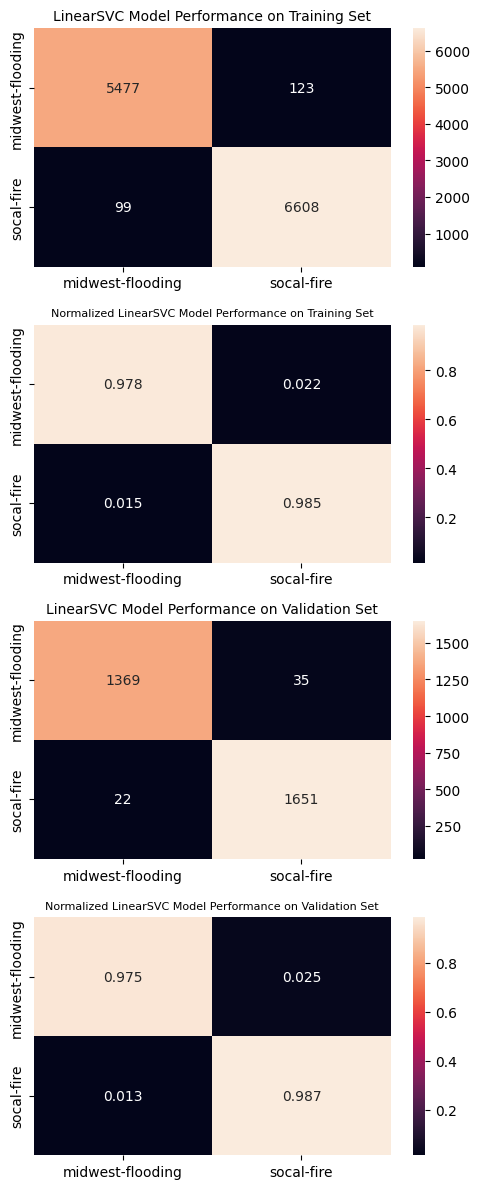

In [50]:
from sklearn.metrics import confusion_matrix

print(classification_report(y_val, svc_val_preds, digits=3))

plt.subplots(figsize=(5,12))

plt.subplot(4, 1, 1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, svc_train_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('LinearSVC Model Performance on Training Set', fontsize=10)

plt.subplot(4, 1, 2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, svc_train_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized LinearSVC Model Performance on Training Set', fontsize=8)

plt.subplot(4, 1, 3)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, svc_val_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('LinearSVC Model Performance on Validation Set', fontsize=10)

plt.subplot(4, 1, 4)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, svc_val_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized LinearSVC Model Performance on Validation Set', fontsize=8)

plt.tight_layout()
plt.show()

In [33]:
# RandomForestClassifier Feature Selection (runtime: ~45sec)
from sklearn.ensemble import RandomForestClassifier

def rfc_feature_selection(features):
  feature_scores = []

  for combo in features:
    X_train, X_val, y_train, y_val = train_test_split(X[combo], y, test_size=0.2, random_state=42)
    pipe = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=42))])
    feature_scores.append((combo, pipe.fit(X_train, y_train).score(X_train, y_train)))

  return feature_scores

feature_combinations = [['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold',	'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold'],
                        ['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int', 'lbp_var',	'lbp_mean',	'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']]

print(f'Best training score among feature combinations: {max(rfc_feature_selection(feature_combinations))[1]:.3f}')

rfc_best_params = max(rfc_feature_selection(feature_combinations))[0]
print(f'Best parameters for RandomForestClassifier: {rfc_best_params}')

Best training score among feature combinations: 1.000
Best parameters for RandomForestClassifier: ['lbp_var', 'lbp_mean', 'sobel_mean', 'gabor_7_var', 'gabor_3_var', 'area of red pixels at 150 threshold', 'area of green pixels at 150 threshold', 'area of blue pixels at 150 threshold']


In [36]:
# RandomForestClassifier Grid Search (runtime: ~38m)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('scaler', StandardScaler()),
                 ('rfc', RandomForestClassifier(random_state=42))])

param_grid = {'rfc__n_estimators' : [10, 100],
              'rfc__max_features' : ['sqrt', 'log2', 0.33],
              'rfc__max_depth' : [1, 2, 5, 10]}

best_X = X[rfc_best_params]

grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(best_X, y)

print(f'Best score: {grid_search.best_score_:.3f}')
print(f'Best hyperparameters for RandomForestClassifier model: {grid_search.best_params_}')

Best score: 0.985
Best hyperparameters for RandomForestClassifier model: {'rfc__max_depth': 10, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 10}


In [47]:
optimal_pipe = Pipeline([('scaler', StandardScaler()),
                         ('rfc', RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=10, random_state=42))])

X_train, X_val, y_train, y_val = train_test_split(best_X, y, test_size=0.2, random_state=42)
optimal_pipe.fit(X_train, y_train)
rfc_train_preds = optimal_pipe.predict(X_train)
rfc_train_score = optimal_pipe.score(X_train, y_train)
rfc_val_preds = optimal_pipe.predict(X_val)
rfc_val_score = optimal_pipe.score(X_val, y_val)
rfc_cv_score = cross_val_score(optimal_pipe, best_X, y, cv=10)
print(f'Initial training score: {rfc_train_score}')
print(f'Initial validation score: {rfc_val_score}')
print(f'Average cross-validation score across 10 folds: {rfc_cv_score.mean()}')

Initial training score: 0.994799707483546
Initial validation score: 0.9840753981150471
Average cross-validation score across 10 folds: 0.9851139129913113


              precision    recall  f1-score   support

           0      0.988     0.977     0.982      1404
           1      0.981     0.990     0.985      1673

    accuracy                          0.984      3077
   macro avg      0.984     0.984     0.984      3077
weighted avg      0.984     0.984     0.984      3077



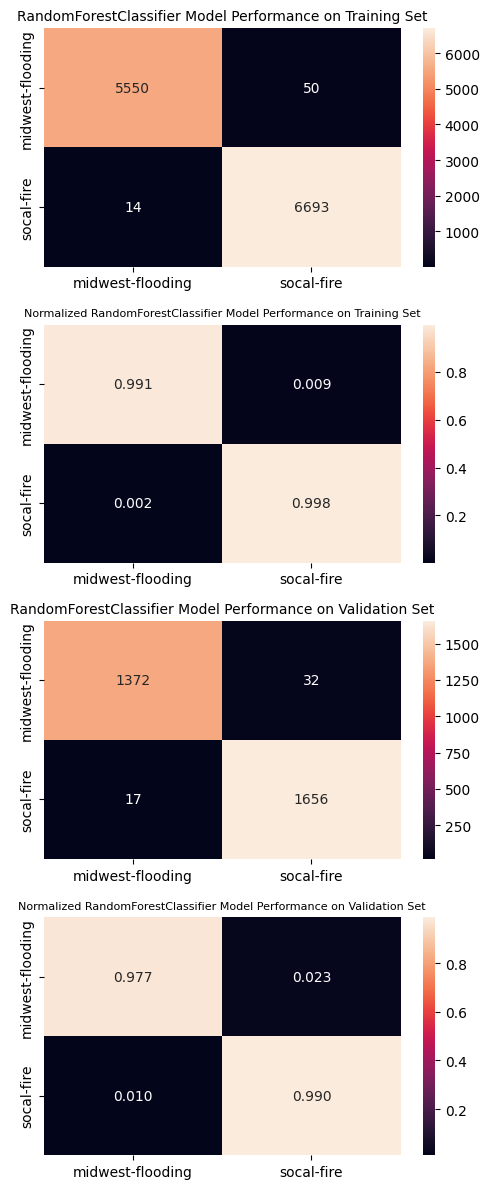

In [48]:
plt.subplots(figsize=(5,12))

print(classification_report(y_val, rfc_val_preds, digits=3))

plt.subplot(4, 1, 1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, rfc_train_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('RandomForestClassifier Model Performance on Training Set', fontsize=10)

plt.subplot(4, 1, 2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, rfc_train_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized RandomForestClassifier Model Performance on Training Set', fontsize=8)

plt.subplot(4, 1, 3)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, rfc_val_preds), index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.0f', annot=True)
plt.title('RandomForestClassifier Model Performance on Validation Set', fontsize=10)

plt.subplot(4, 1, 4)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, rfc_val_preds, normalize='true'),
                         index=['midwest-flooding', 'socal-fire'], columns=['midwest-flooding', 'socal-fire']), fmt='.3f', annot=True)
plt.title('Normalized RandomForestClassifier Model Performance on Validation Set', fontsize=8)

plt.tight_layout()
plt.show()

In [41]:
print(f'LinearSVC vs. RandomForestClassifier Mean Cross-Validation Scores: {svc_cv_score.mean()} vs. {rfc_cv_score.mean()}')
print(f'LinearSVC vs. RandomForestClassifier Training Scores: {svc_train_score} vs. {rfc_train_score}')
print(f'LinearSVC vs. RandomForestClassifier Validation Scores: {svc_val_score} vs. {rfc_val_score}')

LinearSVC vs. RandomForestClassifier Mean Cross-Validation Scores: 0.9817337858927528 vs. 0.9851139129913113
LinearSVC vs. RandomForestClassifier Training Scores: 0.9822052490452587 vs. 0.994799707483546
LinearSVC vs. RandomForestClassifier Validation Scores: 0.9805004874878128 vs. 0.9840753981150471
